<table border="0">
    <tr>
        <td>
            <img src="https://ictd2016.files.wordpress.com/2016/04/microsoft-research-logo-copy.jpg" style="width 30px;" />
             </td>
        <td>
            <img src="https://www.microsoft.com/en-us/research/wp-content/uploads/2016/12/MSR-ALICE-HeaderGraphic-1920x720_1-800x550.jpg" style="width 100px;"/></td>
        </tr>
</table>

# Double Machine Learning: Use Cases and Examples

Double Machine Learning (DML) is an algorithm that applies arbitrary machine learning methods
to fit the treatment and response, then uses a linear model to predict the response residuals
from the treatment residuals.

The EconML SDK implements the following DML classes:
* DMLCateEstimator: suitable for estimating heterogeneous treatment effects.
* SparseLinearDMLCateEstimator: suitable for the case when $W$ is high dimensional vector and both the first stage and second stage estimate are linear.

In ths notebook, we show the performance of the DML on both synthetic data and observational data.

**Notebook contents:**

1. Example usage with single continuous treatment synthetic data
2. Example usage with single binary treatment synthetic data
3. Example usage with multiple continuous treatment synthetic data
4. Example usage with single continuous treatment observational data
5. Example usage with multiple continuous treatment, multiple outcome observational data

In [1]:
%load_ext autoreload
%autoreload 2

In [25]:
import econml

In [26]:
## Ignore warnings
import warnings
warnings.filterwarnings('ignore') 

In [27]:
# Main imports
from econml.dml import LinearDMLCateEstimator,SparseLinearDMLCateEstimator  

# Helper imports
import numpy as np
from itertools import product
from sklearn.linear_model import Lasso, MultiTaskLasso, LassoCV, LogisticRegression, LogisticRegressionCV,LinearRegression,MultiTaskElasticNet,MultiTaskElasticNetCV
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier,GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import matplotlib
from sklearn.multioutput import MultiOutputRegressor

%matplotlib inline

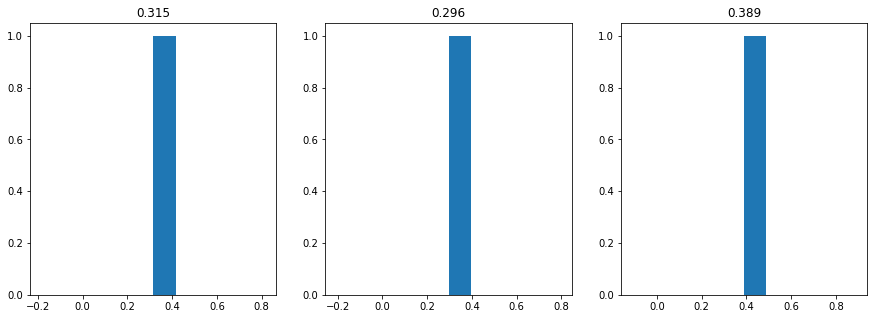

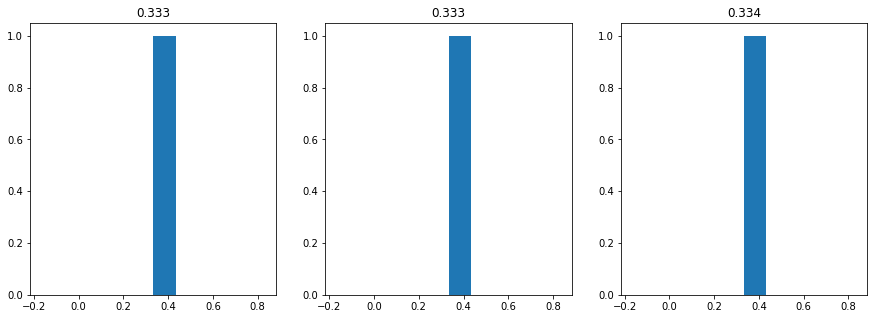

In [90]:
from econml.utilities import WeightedKFold
import numpy as np
def experiment():
    weight_mass = []
    len_mass = []
    for _ in range(1):
        n_samples= 1000
        X = np.random.normal(0, 1, size=(n_samples,1))
        y = np.random.normal(0, 1, size=(n_samples,))
        sample_weight = np.random.choice(10, size=n_samples)
        sample_weight = sample_weight
        total_weight = np.sum(sample_weight)
        n_splits = 3
        wkf = WeightedKFold(n_splits=n_splits, tol=.1)
        weight_mass.append([])
        len_mass.append([])
        for train_index, test_index in wkf.split(X, y, sample_weight=sample_weight):
            len_mass[-1].append(len(test_index)/n_samples)
            weight_mass[-1].append(np.sum(sample_weight[test_index])/total_weight)
    
    return weight_mass, len_mass

weight_mass, len_mass = experiment()
plt.figure(figsize=(15,5))
for it in range(n_splits):
    plt.subplot(1, n_splits, it+1)
    plt.hist(np.array(len_mass)[:, it], label='{}'.format(it))
    plt.title("{:.3f}".format(np.mean(np.array(len_mass)[:, it])))
plt.show()
plt.figure(figsize=(15,5))
for it in range(n_splits):
    plt.subplot(1, n_splits, it+1)
    plt.hist(np.array(weight_mass)[:, it], label='{}'.format(it))
    plt.title("{:.3f}".format(np.mean(np.array(weight_mass)[:, it])))
plt.show()

In [91]:
kf = WeightedKFold()
L = [[1, []], [2, []], [3, []], [7, []], [11, []]]
kf._trim(L, .5)
print(L)

[[1, []], [3, []], [7, []]]


In [93]:
import cProfile
import re
cProfile.run('experiment()')

         5695291 function calls in 52.368 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   52.368   52.368 <ipython-input-90-e5acea873556>:3(experiment)
        1    0.000    0.000   52.368   52.368 <string>:1(<module>)
        2    0.000    0.000    0.000    0.000 __init__.py:489(cast)
        2    0.000    0.000    0.000    0.000 _internal.py:257(__init__)
        2    0.000    0.000    0.000    0.000 _internal.py:260(__array_interface__)
        2    0.000    0.000    0.000    0.000 _internal.py:272(_get_void_ptr)
        2    0.000    0.000    0.000    0.000 _internal.py:289(__init__)
        2    0.000    0.000    0.000    0.000 _internal.py:338(data)
       10    0.000    0.000    0.000    0.000 arraysetops.py:138(_unpack_tuple)
       10    0.000    0.000    0.000    0.000 arraysetops.py:151(unique)
       10    0.000    0.000    0.000    0.000 arraysetops.py:299(_unique1d)
        5    0

In [80]:
import cProfile
import re
cProfile.run('experiment()')

         2707484 function calls in 8.224 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.001    0.001    8.224    8.224 <ipython-input-76-97ef6e3f075a>:3(experiment)
        1    0.000    0.000    8.224    8.224 <string>:1(<module>)
      200    0.000    0.000    0.000    0.000 arraysetops.py:138(_unpack_tuple)
      200    0.001    0.000    0.004    0.000 arraysetops.py:151(unique)
      200    0.002    0.000    0.003    0.000 arraysetops.py:299(_unique1d)
      100    0.001    0.000    0.003    0.000 arraysetops.py:484(in1d)
      100    0.001    0.000    0.008    0.000 arraysetops.py:745(setdiff1d)
      100    0.000    0.000    0.001    0.000 fromnumeric.py:1966(sum)
       20    0.000    0.000    0.000    0.000 fromnumeric.py:2083(any)
       20    0.000    0.000    0.000    0.000 fromnumeric.py:2664(prod)
      140    0.000    0.000    0.001    0.000 fromnumeric.py:69(_wrapreduction)
      140    0.000 

In [56]:
S = np.arange(5)
n = len(S)
Li = np.array([(0, [], 0)])
perS = S + np.random.uniform(-.5, .5, size=(len(S)))
for i in range(n):
    add_i = np.copy(Li)
    add_i[:, 0] += S[i]
    add_i[:, 2] += perS[i]
    add_i[:, 1] += np.array([[i]]*len(Li))

ValueError: non-broadcastable output operand with shape (1,) doesn't match the broadcast shape (1,1)

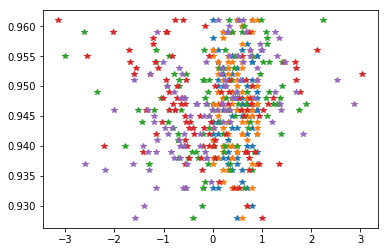

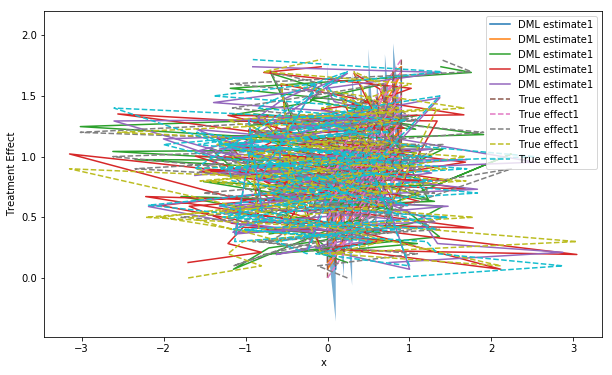

In [71]:
# DGP constants
from econml.tests.test_statsmodels import StatsModelsOLS
from econml.utilities import StatsModelsLinearRegression
np.random.seed(12)
n=500
n_x=5
n_exp = 1000
cov1, cov2 = 0, 0
X_test = np.random.normal(size=(100, n_x))
X_test[:, :2] = np.array(list(product(np.arange(0, 1, 0.1), repeat=2)))

for _ in range(n_exp):
    epsilon_sample=lambda n: np.random.uniform(-1,1,size=n)
    eta_sample=lambda n: np.random.uniform(-1,1,size=n)
    X=np.random.uniform(0, 1, size=(n,n_x))
    Y=np.sum(X[:, :2], axis=1) + epsilon_sample(n)
    est = StatsModelsLinearRegression(fit_args={'cov_type':'HC1'})
    est.fit(X, Y)
    te_pred = est.predict(X_test)
    te_pred_int = est.predict_interval(X_test, alpha=0.05)
    expected_te1 = np.sum(X_test[:, :2], axis=1)
    cov1 += (expected_te1>=te_pred_int[0]) & (expected_te1<=te_pred_int[1])

plt.figure()
plt.plot(X_test, cov1/n_exp, '*', label='1')
plt.show()

plt.figure(figsize=(10,6))
plt.plot(X_test, te_pred, label='DML estimate1')
plt.fill_between(X_test[:,0], te_pred_int[0], te_pred_int[1], alpha=.6)
plt.plot(X_test, expected_te1, '--', label='True effect1')
plt.ylabel("Treatment Effect")
plt.xlabel("x")
plt.legend()
plt.show()

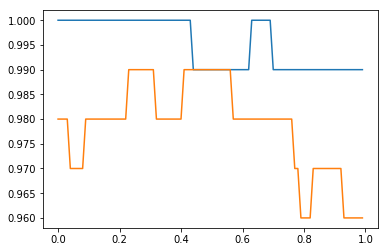

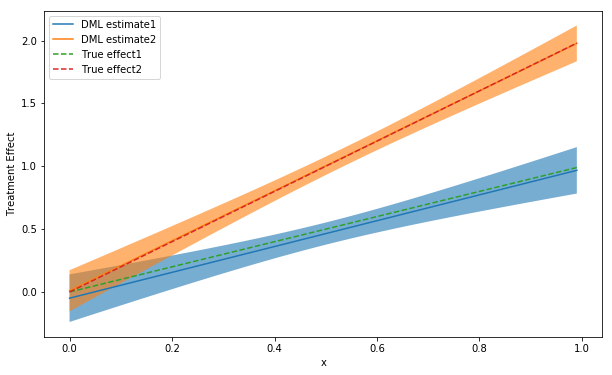

In [92]:
# DGP constants
from econml.tests.test_statsmodels import StatsModelsOLS
from sklearn.linear_model import MultiTaskLassoCV
np.random.seed(12)
n=1000
n_w=5
support_size=1
n_x=1
n_exp = 100
support_Y=np.random.choice(range(n_w),size=support_size,replace=False)
coefs_Y=np.random.uniform(0,1,size=support_size)
support_T=support_Y
coefs_T=np.random.uniform(0,1,size=support_size)
X_test = np.array(list(product(np.arange(0, 1, 0.01), repeat=n_x)))
cov1, cov2 = 0, 0
for _ in range(n_exp):
    epsilon_sample=lambda n: np.random.uniform(-1,1,size=n)
    eta_sample=lambda n: np.random.uniform(-1,1,size=n)
    W=np.random.normal(0,1,size=(n,n_w))
    X=np.random.uniform(0,1,size=(n,n_x))
    TE1=np.array([x_i[0] for x_i in X])
    TE2=np.array([2*x_i[0] for x_i in X])
    T=np.dot(W[:,support_T],coefs_T)+eta_sample(n)
    Y=TE1*T+TE2*T**2+np.dot(W[:,support_Y],coefs_Y)+epsilon_sample(n)
    est = LinearDMLCateEstimator(model_y=RandomForestRegressor(n_estimators=100, min_samples_leaf=10), #LassoCV(cv=5, n_alphas=10), #LinearRegression(fit_intercept=True),
                                 model_t=RandomForestRegressor(n_estimators=100, min_samples_leaf=10), #MultiTaskLassoCV(cv=5, n_alphas=10), #LinearRegression(fit_intercept=True),
                                 n_splits=2,
                                 linear_first_stages=False,
                                 featurizer=PolynomialFeatures(degree=1, include_bias=True))
    poly = PolynomialFeatures(degree=2, include_bias=False)
    from econml.inference import StatsModelsInference
    est.fit(Y, np.concatenate((T.reshape(-1,1), T.reshape(-1,1)**2), axis=1), X, W,
            inference=StatsModelsInference(cov_type='HC1'))
    te_pred=est.const_marginal_effect(X_test)
    te_pred_int = est.const_marginal_effect_interval(X_test, alpha=.01)
    cov1 += (expected_te1>=te_pred_int[0][:, 0]) & (expected_te1<=te_pred_int[1][:, 0])
    cov2 += (expected_te2>=te_pred_int[0][:, 1]) & (expected_te2<=te_pred_int[1][:, 1])

plt.figure()
plt.plot(X_test, cov1/n_exp, label='1')
plt.plot(X_test, cov2/n_exp, label='2')
plt.show()

plt.figure(figsize=(10,6))
plt.plot(X_test, te_pred[:,0], label='DML estimate1')
plt.fill_between(X_test[:,0], te_pred_int[0][:, 0], te_pred_int[1][:, 0], alpha=.6)
plt.plot(X_test, te_pred[:,1], label='DML estimate2')
plt.fill_between(X_test[:,0], te_pred_int[0][:, 1], te_pred_int[1][:, 1], alpha=.6)
expected_te1 = np.array([x_i[0] for x_i in X_test])
expected_te2=np.array([2*x_i[0] for x_i in X_test])
plt.plot(X_test, expected_te1, '--', label='True effect1')
plt.plot(X_test, expected_te2, '--', label='True effect2')
plt.ylabel("Treatment Effect")
plt.xlabel("x")
plt.legend()
plt.show()

In [99]:
X = np.random.binomial(1, .5, size=(2, 5))
print(X)
print(np.repeat(X, 2, axis=0))

[[0 1 1 1 1]
 [0 0 1 1 1]]
[[0 1 1 1 1]
 [0 1 1 1 1]
 [0 0 1 1 1]
 [0 0 1 1 1]]


In [12]:

n = 1000
d = 10
X = np.random.binomial(1, .5, size=(n, d))
T = np.random.binomial(1, .5, size=(n,))
y = (X[:, 0] + .5)*T + X[:, 0] + (0*X[:,0] + 1)*np.random.normal(0, 1, size=(n,))
from econml.bootstrap import BootstrapEstimator
from econml.dml import LinearDMLCateEstimator
est = LinearDMLCateEstimator(model_y=LinearRegression(), model_t=LinearRegression(),
                             model_final=LinearRegression(fit_intercept=False)).fit(y, T, X, None, inference='bootstrap')
est.const_marginal_effect_interval()

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


ValueError: X shape does not match training shape

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   54.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished


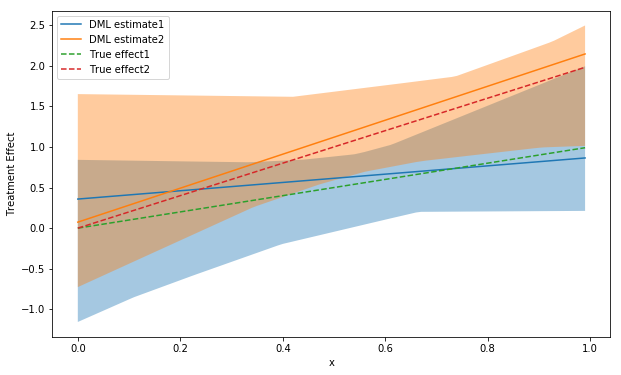

In [18]:
np.random.seed(123)
n=1000
n_w=5
support_size=5
n_x=1
support_Y=np.random.choice(range(n_w),size=support_size,replace=False)
coefs_Y=np.random.uniform(0,1,size=support_size)
epsilon_sample=lambda n: np.random.uniform(-1,1,size=n)
support_T=support_Y
coefs_T=np.random.uniform(0,1,size=support_size)
eta_sample=lambda n: np.random.uniform(-1,1,size=n)
W=np.random.normal(0,1,size=(n,n_w))
X=np.random.uniform(0,1,size=(n,n_x))
TE1=np.array([x_i[0] for x_i in X])
TE2=np.array([2*x_i[0] for x_i in X])
T=np.dot(W[:,support_T],coefs_T)+eta_sample(n)
Y=TE1*T+TE2*T**2+np.dot(W[:,support_Y],coefs_Y)+epsilon_sample(n)
X_test = np.array(list(product(np.arange(0, 1, 0.01), repeat=n_x)))
est = LinearDMLCateEstimator(model_y=LinearRegression(fit_intercept=True),
                             model_t=LinearRegression(fit_intercept=True),
                             n_splits=2,
                             featurizer=PolynomialFeatures(degree=1, include_bias=True))
poly = PolynomialFeatures(degree=2)
est.fit(Y, np.concatenate((T.reshape(-1,1), T.reshape(-1,1)**2), axis=1), X, poly.fit_transform(W), inference='bootstrap')
te_pred=est.const_marginal_effect(X_test)
te_pred_int = est.const_marginal_effect_interval(X_test, alpha=.01)
plt.figure(figsize=(10,6))
plt.plot(X_test, te_pred[:,0], label='DML estimate1')
plt.fill_between(X_test[:,0], te_pred_int[0][:, 0], te_pred_int[1][:, 0], alpha=.4)
plt.plot(X_test, te_pred[:,1], label='DML estimate2')
plt.fill_between(X_test[:,0], te_pred_int[0][:, 1], te_pred_int[1][:, 1], alpha=.4)
expected_te1 = np.array([x_i[0] for x_i in X_test])
expected_te2=np.array([2*x_i[0] for x_i in X_test])
plt.plot(X_test, expected_te1, '--', label='True effect1')
plt.plot(X_test, expected_te2, '--', label='True effect2')
plt.ylabel("Treatment Effect")
plt.xlabel("x")
plt.legend()
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

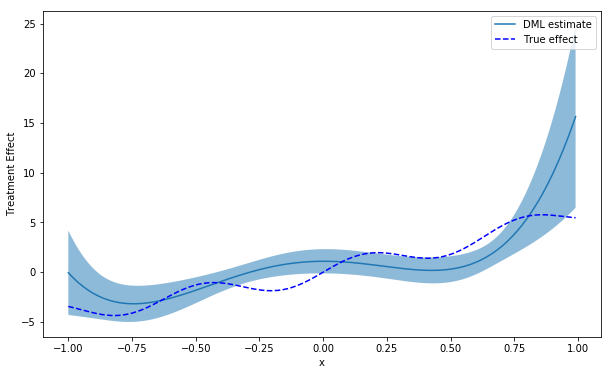

In [26]:
def exp_te(x):
    return np.sin(10*x[0]) + 5 * x[0] + x[0]**2
np.random.seed(1234)
n=100
n_w=30
support_size=5
n_x=1
support_Y=np.random.choice(range(n_w),size=support_size,replace=False)
coefs_Y=np.random.uniform(0,1,size=support_size)
epsilon_sample=lambda n:np.random.uniform(-1,1,size=n)
support_T=support_Y
coefs_T = np.random.uniform(0, 1, size=support_size)
eta_sample = lambda n: np.random.uniform(-1, 1, size=n) 
W = np.random.normal(0, 1, size=(n, n_w))
X = np.random.uniform(-1, 1, size=(n, n_x))
TE = np.array([exp_te(x_i) for x_i in X])
log_odds = np.dot(W[:, support_T], coefs_T) + eta_sample(n)
T_sigmoid = 1/(1 + np.exp(-log_odds))
T = np.array([np.random.binomial(1, p) for p in T_sigmoid])
Y = TE * T + np.dot(W[:, support_Y], coefs_Y) + epsilon_sample(n)
X_test = np.array(list(product(np.arange(-1, 1, 0.01), repeat=n_x)))
est = LinearDMLCateEstimator(model_y=LassoCV(),
                             model_t=LogisticRegression(solver='lbfgs'),
                             featurizer=PolynomialFeatures(degree=4, include_bias=True),
                             n_splits=6,
                             discrete_treatment=True)
from econml.inference import StatsModelsInference, BootstrapInference
est.fit(Y, T, X, W, inference='statsmodels')
te_pred = est.effect(X_test)
te_pred_int = est.effect_interval(X_test, alpha=.01)
plt.figure(figsize=(10,6))
plt.plot(X_test,te_pred,label='DML estimate')
expected_te=np.array([exp_te(x_i) for x_i in X_test])
plt.plot(X_test,expected_te,'b--',label='True effect')
plt.fill_between(X_test[:, 0], te_pred_int[0], te_pred_int[1], alpha=.5)
plt.ylabel('Treatment Effect')
plt.xlabel('x')
plt.legend()
plt.show()

In [15]:
import numpy as np
from econml.tests.test_statsmodels import _summarize
from econml.utilities import WeightedLassoCV, WeightedMultiTaskLassoCV
from sklearn.linear_model import MultiTaskLassoCV, LassoCV, MultiTaskLasso
np.random.seed(1235)
n=1000
d=4
p=2

for _ in range(1):
    X = np.random.binomial(1, .8, size=(n, d)).astype(np.float)
    X_test = np.random.binomial(1, .5, size=(n, d))
    y = X[:, [0]*p] + 1 + (1*X[:, [0]] + 1)*np.random.normal(0, 1, size=(n,p))
    X_sum = np.unique(X, axis=0)
    n_sum = np.zeros(X_sum.shape[0])
    if p==1:
        y = y.ravel()
        y_sum = np.zeros(X_sum.shape[0])
    else:
        y_sum = np.zeros((X_sum.shape[0], p))
    for it, x in enumerate(X_sum):
        mask = (X==x).all(axis=1)
        y_sum[it] = np.mean(y[mask], axis=0, keepdims=True)
        n_sum[it] = np.sum(mask)

    from econml.utilities import WeightedModelWrapper
    from sklearn.linear_model import Lasso, LinearRegression
    
    alphas = [1e-8, 1e-4, .001, .005, .01, .1, 1, 10]
    for fit_intercept in [True]:
        print(fit_intercept)
        est = MultiTaskLassoCV(cv=2, alphas=alphas, fit_intercept=fit_intercept,
                    tol=1e-6, max_iter=10000, random_state=123).fit(X, y)
        lr = WeightedMultiTaskLassoCV(cv=2, alphas=alphas, fit_intercept=fit_intercept,
                    tol=1e-12, random_state=123).fit(X_sum, y_sum, sample_weight=n_sum)
        with np.printoptions(formatter={'float': '{:.4f}'.format}, suppress=True):
            print(est.alpha_)
            print(np.hstack([est.alphas_.reshape(-1, 1), est.mse_path_]))
            print(lr.alpha_)
            print(np.hstack([lr.alphas_.reshape(-1, 1), lr.mse_path_]))
        print(lr.intercept_)
        print(lr.coef_)
        print(est.intercept_)
        print(est.coef_)
        #assert np.all(np.abs(est.intercept_-lr.intercept_)<=1e-10), print(est.intercept_, lr.intercept_)
        #assert np.all(np.abs(est.coef_-lr.coef_)<=1e-10), print(est.coef_, lr.coef_)
        #assert np.all(np.abs(est.predict(X_test) - lr.predict(X_test))<=1e-10)

True
0.01
[[10.0000 3.7325 3.2482]
 [1.0000 3.7325 3.2482]
 [0.1000 3.5739 3.0906]
 [0.0100 3.5478 3.0802]
 [0.0050 3.5477 3.0841]
 [0.0010 3.5482 3.0876]
 [0.0001 3.5483 3.0885]
 [0.0000 3.5483 3.0886]]
0.01
[[10.0000 0.1362 0.2778]
 [1.0000 0.1362 0.2778]
 [0.1000 0.0518 0.3285]
 [0.0100 0.0596 0.2483]
 [0.0050 0.0612 0.6868]
 [0.0010 0.0635 1.3472]
 [0.0001 0.0642 1.7713]
 [0.0000 0.0643 1.8228]]
[0.995228   0.89605018]
[[ 0.9455227   0.07212538 -0.04128296 -0.        ]
 [ 1.10842242  0.10227525  0.05443657 -0.        ]]
[0.995228   0.89605018]
[[ 0.9455227   0.07212538 -0.04128296 -0.        ]
 [ 1.10842242  0.10227525  0.05443657 -0.        ]]


In [34]:
import numpy as np
y = np.random.randint(0, 2, size=(10,))
print(y)
for t in np.unique(y, axis=0):
    print(t)
    if y.ndim==2:
        print(np.argwhere(np.all(y==t, axis=1)))
    else:
        print(np.argwhere(y==t))

[1 0 0 0 1 0 1 0 1 0]
0
[[1]
 [2]
 [3]
 [5]
 [7]
 [9]]
1
[[0]
 [4]
 [6]
 [8]]


In [23]:
splits = [[] for t in range(4)]
for t in range(4):
    print(splits[t])
    splits[t].extend([0, 1])
print(splits)

[]
[]
[]
[]
[[0, 1], [0, 1], [0, 1], [0, 1]]


In [31]:
from econml.utilities import GridSearchCVList
from sklearn.linear_model import LinearRegression, MultiTaskLassoCV, MultiTaskLasso, Lasso
from econml.utilities import WeightedModelWrapper, LassoCVWrapper, WeightedLasso, GridSearchCVList
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
est = GridSearchCVList([LinearRegression(),
                 WeightedLasso(alpha=.05, fit_intercept=False, tol=1e-6, random_state=123),
                 RandomForestRegressor(n_estimators=100, max_depth=3, min_samples_leaf=10, random_state=123),
                 GradientBoostingRegressor(n_estimators=20, max_depth=3, min_samples_leaf=10, random_state=123)],
                 param_grid_list=[{},
                                  {},
                                  {},
                                  {}],
                 cv=3,
                 iid=True).fit(X, y)

WeightedLasso(alpha=0.05, copy_X=True, fit_intercept=False, max_iter=1000,
              normalize=False, positive=False, precompute=False,
              random_state=123, selection='cyclic', tol=1e-06,
              warm_start=False)


In [72]:
print("test", file=[None, open("test.txt", "a")])

AttributeError: 'list' object has no attribute 'write'

In [24]:
for gcv in est._gcv_list:
    print(gcv.best_score_)
    print(gcv.best_params_)
    print(gcv.cv_results_)

-0.014610328239809095
{}
{'mean_fit_time': array([0.00066535]), 'std_fit_time': array([0.00047047]), 'mean_score_time': array([0.00066725]), 'std_score_time': array([0.00047182]), 'params': [{}], 'split0_test_score': array([-0.05471556]), 'split1_test_score': array([0.00452196]), 'split2_test_score': array([0.00648896]), 'mean_test_score': array([-0.01461033]), 'std_test_score': array([0.02841257]), 'rank_test_score': array([1])}
-0.009438144930192441
{}
{'mean_fit_time': array([0.00099444]), 'std_fit_time': array([6.14670039e-06]), 'mean_score_time': array([0.00100644]), 'std_score_time': array([5.95993463e-06]), 'params': [{}], 'split0_test_score': array([-0.05463273]), 'split1_test_score': array([0.00784569]), 'split2_test_score': array([0.01864075]), 'mean_test_score': array([-0.00943814]), 'std_test_score': array([0.03230704]), 'rank_test_score': array([1])}
-0.016348038277418608
{}
{'mean_fit_time': array([0.06600046]), 'std_fit_time': array([0.01177326]), 'mean_score_time': arra

In [15]:
for e1, e2 in zip([1,2,3], [1,2]):
    print(e1, e2)

1 1
2 2


In [11]:
import numpy as np
from econml.tests.test_statsmodels import _summarize
np.random.seed(12)
n=5000
d=3
p=1

for _ in range(10):
    X = np.random.binomial(1, .8, size=(n, d))
    y = X[:, [0]*p] + 1 + (1*X[:, [0]] + 1)*np.random.normal(0, 1, size=(n,p))
    X_sum = np.unique(X, axis=0)
    n_sum = np.zeros(X_sum.shape[0])
    if p==1:
        y = y.ravel()
        y_sum = np.zeros(X_sum.shape[0])
    else:
        y_sum = np.zeros((X_sum.shape[0], p))
    for it, x in enumerate(X_sum):
        mask = (X==x).all(axis=1)
        y_sum[it] = np.mean(y[mask], axis=0, keepdims=True)
        n_sum[it] = np.sum(mask)
    
    from econml.utilities import WeightedModelWrapper
    from sklearn.linear_model import Lasso, LinearRegression, LassoCV

    est = LassoCV(cv=3, alphas=[1e-4, 1e-3, 1e-2, .1, 1, 10], fit_intercept=False, max_iter=10000, tol=1e-4, random_state=123).fit(X, y)
    lr = WeightedModelWrapper(LassoCV(cv=3, alphas=[1e-4, 1e-3, 1e-2, .1, 1, 10], fit_intercept=False, max_iter=10000, tol=1e-4, random_state=123)).fit(X_sum, y_sum, sample_weight=n_sum)
    #assert np.abs(est.alpha_ - lr.alpha_) <= 1e-10, "{} != {}".format(est.alpha_, lr.alpha_)
    assert np.all(np.abs(est.coef_-lr.coef_)<=1e-10), "{} != {}".format(est.coef_, lr.coef_)

AssertionError: [1.32834013 0.41398926 0.3979608 ] != [1.32310831 0.4094063  0.3934184 ]

In [164]:
import numpy as np
from econml.tests.test_statsmodels import _summarize
np.random.seed(12)
n=5000
d=3
p=1

for it in range(50):
    X = np.random.binomial(1, .8, size=(n, d))
    X_test = np.unique(np.random.binomial(1, .5, size=(100, d)), axis=0)
    y = X[:, [0]*p] + 1 + (1*X[:, [0]] + 1)*np.random.normal(0, 1, size=(n,p))
    X_sum = np.unique(X, axis=0)
    n_sum = np.zeros(X_sum.shape[0])
    if p==1:
        y = y.ravel()
        y_sum = np.zeros(X_sum.shape[0])
    else:
        y_sum = np.zeros((X_sum.shape[0], p))
    for it, x in enumerate(X_sum):
        mask = (X==x).all(axis=1)
        y_sum[it] = np.mean(y[mask], axis=0, keepdims=True)
        n_sum[it] = np.sum(mask)
    
    from econml.utilities import WeightedModelWrapper
    from sklearn.linear_model import Lasso, LinearRegression, LassoCV
    from sklearn.ensemble import RandomForestRegressor

    est = RandomForestRegressor(n_estimators=1, bootstrap=False, random_state=123).fit(X, y)
    lr = RandomForestRegressor(n_estimators=1, bootstrap=False, random_state=123).fit(X_sum, y_sum, sample_weight=n_sum)
    assert np.all(np.abs(est.predict(X_test)-lr.predict(X_test))<=1e-10), "{}: {} != {}".format(it,
                                                                                                est.predict(X_test),
                                                                                                lr.predict(X_test))

AssertionError: 7: [0.94585124 0.94600339 1.05960627 1.06341396 2.00409182 2.05791732
 1.94695593 1.99703607] != [0.94596592 0.94596592 1.05960627 1.06341396 2.00409182 2.05791732
 1.94695593 1.99703607]

In [ ]:
import numpy as np
from econml.tests.test_statsmodels import _summarize
np.random.seed(12)
n=5000
d=3
p=1
for it in range(50):
    X = np.random.binomial(1, .8, size=(n, d))
    X_test = np.unique(np.random.binomial(1, .5, size=(100, d)), axis=0)
    y = X[:, [0]*p] + 1 + (1*X[:, [0]] + 1)*np.random.normal(0, 1, size=(n,p))
    X_sum = np.unique(X, axis=0)
    n_sum = np.zeros(X_sum.shape[0])
    if p==1:
        y = y.ravel()
        y_sum = np.zeros(X_sum.shape[0])
    else:
        y_sum = np.zeros((X_sum.shape[0], p))
    for it, x in enumerate(X_sum):
        mask = (X==x).all(axis=1)
        y_sum[it] = np.mean(y[mask], axis=0, keepdims=True)
        n_sum[it] = np.sum(mask)

In [33]:
import numpy as np
from econml.tests.test_statsmodels import _summarize
from econml.utilities import StatsModelsWrapperOLD
import numpy as np
np.random.seed(12)
n=1000
d=2
p=1

for it in range(1):
    #est = StatsModelsWrapperOLD(fit_args={'cov_type':'nonrobust'}).fit(X, y)
    n_mc = 1000
    cov = 0
    for t in range(n_mc):
        X = np.random.binomial(1, .8, size=(n, d))
        X_test = np.unique(np.random.binomial(1, .5, size=(100, d)), axis=0)
        y = X[:, [0]*p] + 1 + (0*X[:, [0]] + 1)*np.random.normal(0, 1, size=(n,p))
        true_coef = np.zeros((d,))
        true_coef[0] = 1
        X_sum = np.unique(X, axis=0)
        n_sum = np.zeros(X_sum.shape[0])
        if p==1:
            y = y.ravel()
            y_sum = np.zeros(X_sum.shape[0])
        else:
            y_sum = np.zeros((X_sum.shape[0], p))
        for it, x in enumerate(X_sum):
            mask = (X==x).all(axis=1)
            y_sum[it] = np.mean(y[mask], axis=0, keepdims=True)
            n_sum[it] = np.sum(mask)

        from econml.utilities import WeightedModelWrapper
        from sklearn.linear_model import Lasso, LinearRegression, LassoCV
        from sklearn.ensemble import RandomForestRegressor
        
        lr = StatsModelsWrapperOLD(fit_args={'cov_type':'nonrobust', 'use_t':False}).fit(X, y)
        #lr = StatsModelsWrapperOLD(fit_args={'cov_type':'nonrobust', 'use_t':False}).fit(X_sum, y_sum, sample_weight=n_sum)
        low, high = lr.coef__interval(alpha=.05)
        cov += (low <= true_coef) & (high >= true_coef)
    print(cov/n_mc)
    #print(est.coef_)
    print(lr.coef_)
    #print(est.results.summary())
    print(lr.results.summary())
    #plt.hist(n_sum)
    #plt.show()
    #assert np.all(np.abs(est.predict(X_test)-lr.predict(X_test))<=1e-10), "{}: {} != {}".format(it,
    #                                                                                            est.predict(X_test),
    #                                                                                            lr.predict(X_test))

[0.945 0.956]
[ 1.11912684 -0.10840013]
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.179
Model:                            WLS   Adj. R-squared:                  0.178
Method:                 Least Squares   F-statistic:                     109.0
Date:                Wed, 25 Sep 2019   Prob (F-statistic):           1.55e-43
Time:                        09:54:03   Log-Likelihood:                -1392.6
No. Observations:                1000   AIC:                             2791.
Df Residuals:                     997   BIC:                             2806.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       

In [253]:
from econml.inference import StatsModelsInference
from econml.tests.test_statsmodels import _summarize
np.random.seed(123)
n = 100000
precision = .01
precision_int = .0001
with np.printoptions(formatter={'float': '{:.4f}'.format}, suppress=True):
    for d in [2, 5]: #n_feats + n_controls
        for d_x in [2]: #n_feats
            for p in [1, 5]: #n_outcomes
                for q in [1, 5]: #n_treatments
                    X = np.random.binomial(1, .5, size=(n, d))
                    T = np.hstack([np.random.binomial(1, .5 + .2*(2*X[:, [1]]-1)) for _ in range(q)])
                    true_effect = lambda x, i: np.hstack([x[:, [0]] + 10*t + i for t in range(p)])
                    y = np.sum((true_effect(X, i)*T[:, [i]] for i in range(q)), axis=0) + X[:, [0]*p] #+ np.random.normal(0, 1, size=(n,p))
                    if p==1:
                        y = y.flatten()
                    X_test = np.random.binomial(1, .5, size=(100, d))
                    est = LinearDMLCateEstimator(model_y=LinearRegression(),
                                                model_t=LinearRegression(),
                                                linear_first_stages=False)
                    est.fit(y, T, X[:, :d_x], X[:, d_x:], inference=StatsModelsInference(cov_type='nonrobust'))
                    coef = est.coef_.reshape(p, q, d_x+1)
                    lower, upper = est.coef__interval(alpha=.001)
                    lower = lower.reshape(p, q, d_x+1)
                    upper = upper.reshape(p, q, d_x+1)
                    for i in range(p):
                        for j in range(q):
                            assert np.abs(coef[i, j, 0] - 10*i - j) < precision, (coef[i,j,0], 10*i+j)
                            assert (lower[i, j, 0] <= 10*i + j + precision_int) & (upper[i, j, 0] >= 10*i+j-precision_int), (lower[i,j,0], upper[i,j,0], 10*i+j)
                            assert np.abs(coef[i, j, 1] - 1) < precision, (coef[i, j, 1], 1)
                            assert (lower[i, j, 1] <= 1 + precision_int) & (upper[i, j, 1] >= 1 - precision_int), (lower[i, j, 1], upper[i, j, 1])
                            assert np.all(np.abs(coef[i, j, 2:]) < precision)
                            assert np.all((lower[i, j, 2:] <= precision_int) & (upper[i, j, 2:] >= -precision_int)), (np.max(lower[i, j, 2:]), np.min(upper[i, j, 2:]))

                    XT = np.hstack([X, T])
                    X1, X2, y1, y2, X_final_first, X_final_sec, y_sum_first, y_sum_sec, n_sum_first, n_sum_sec, var_first, var_sec = _summarize(XT, y)
                    X = np.vstack([X1, X2])
                    y = np.concatenate((y1, y2))
                    X_final = np.vstack([X_final_first, X_final_sec])
                    y_sum = np.concatenate((y_sum_first, y_sum_sec))
                    n_sum = np.concatenate((n_sum_first, n_sum_sec))
                    var_sum = np.concatenate((var_first, var_sec))
                    first_half_sum = len(y_sum_first)
                    first_half = len(y1)

                    class SplitterSum:
                        def __init__(self):
                            return
                        def split(self, X, T):
                            return [(np.arange(0, first_half_sum), np.arange(first_half_sum, X.shape[0])), 
                                    (np.arange(first_half_sum, X.shape[0]), np.arange(0, first_half_sum))]

                    est = LinearDMLCateEstimator(model_y = LinearRegression(),
                                        model_t = LinearRegression(),
                                        n_splits=SplitterSum(),
                                        linear_first_stages=False,
                                        discrete_treatment=False).fit(y_sum,
                                                                      X_final[:, d:],
                                                                      X_final[:, :d_x],
                                                                      X_final[:, d_x:d],
                                                                      sample_weight=n_sum,
                                                                      var_weight=var_sum,
                                                                      inference=StatsModelsInference(cov_type='nonrobust'))
                    coef = est.coef_.reshape(p, q, d_x+1)
                    lower, upper = est.coef__interval(alpha=.001)
                    lower = lower.reshape(p, q, d_x+1)
                    upper = upper.reshape(p, q, d_x+1)
                    for i in range(p):
                        for j in range(q):
                            assert np.abs(coef[i, j, 0] - 10*i - j) < precision, (coef[i,j,0], 10*i+j)
                            assert (lower[i, j, 0] <= 10*i + j + precision_int) & (upper[i, j, 0] >= 10*i+j-precision_int), (lower[i,j,0], upper[i,j,0], 10*i+j)
                            assert np.abs(coef[i, j, 1] - 1) < precision, (coef[i, j, 1], 1)
                            assert (lower[i, j, 1] <= 1 + precision_int) & (upper[i, j, 1] >= 1 - precision_int), (lower[i, j, 1], upper[i, j, 1])
                            assert np.all(np.abs(coef[i, j, 2:]) < precision)
                            assert np.all((lower[i, j, 2:] <= precision_int) & (upper[i, j, 2:] >= -precision_int)), (np.max(lower[i, j, 2:]), np.min(upper[i, j, 2:]))


In [15]:
param = np.array([1,2])
param.shape[0]

2

In [113]:
from econml.tests.test_statsmodels import TestStatsModels
#TestStatsModels().test_inference()
#TestStatsModels().test_comp_with_statsmodels()
#TestStatsModels().test_sum_vs_original()
TestStatsModels().test_dml_sum_vs_original_lasso()
#TestStatsModels().test_comp_with_lr()

In [84]:
np.linalg.lstq(WX, [0.3744 1.0679 -2.5034 -0.8559 0.4340 -1.5954 3.3622])

SyntaxError: invalid syntax (<ipython-input-84-acc81c232994>, line 1)

In [114]:
WX = np.array([[0, 0], [1,0], [-2.4875, -2.4875], [1.4577, 1.4577], [0, 0], [-2.4690, -2.4690], [1.5119, 1.5119]])
wy = np.array([0.3744, 1.0679, -2.5034, -0.8559, 0.4340, -1.5954, 3.3622])
print(np.matmul(WX.T, WX))
print(np.ones((2, 2)) @ np.linalg.pinv(WX.T @ WX))

[[17.69434815 16.69434815]
 [16.69434815 16.69434815]]
[[0.         0.05990051]
 [0.         0.05990051]]


In [95]:
print(np.linalg.lstsq(WX, wy, rcond=.2))

(array([0.43539706, 0.42255205]), array([], dtype=float64), 1, array([5.82204278, 0.7017935 ]))


In [141]:
import numpy as np
from econml.tests.test_statsmodels import _summarize
np.random.seed(12)
n=5000
d=2
p=1

for _ in range(10):
    X = np.random.binomial(1, .8, size=(n, d))
    y = X[:, [0]*p] + 1 + (1*X[:, [0]] + 1)*np.random.normal(0, 1, size=(n,p))
    if p==1:
        y = y.ravel()
    X1, X2, y1, y2, X1_sum, X2_sum, y1_sum, y2_sum, n1_sum, n2_sum, _, _ = _summarize(X, y)
    
    X_sum = np.vstack([X1_sum, X2_sum])
    y_sum = np.concatenate((y1_sum, y2_sum))
    n_sum = np.concatenate((n1_sum, n2_sum))
    
    from econml.utilities import WeightedModelWrapper
    from sklearn.linear_model import Lasso, LinearRegression, LassoCV

    est = LassoCV(cv=3, alphas=[1e-4, 1e-3, 1e-2, .1, 1, 10], fit_intercept=False, max_iter=10000, tol=1e-4, random_state=123).fit(X, y)
    lr = WeightedModelWrapper(LassoCV(cv=3, alphas=[1e-4, 1e-3, 1e-2, .1, 1, 10], fit_intercept=False, max_iter=10000, tol=1e-4, random_state=123)).fit(X_sum, y_sum, sample_weight=n_sum)
    #assert np.abs(est.alpha_ - lr.alpha_) <= 1e-10, "{} != {}".format(est.alpha_, lr.alpha_)
    assert np.all(np.abs(est.coef_-lr.coef_)<=1e-10), "{} != {}".format(est.coef_, lr.coef_)

AssertionError: [1.57288904 0.55683656] != [1.56609108 0.54990669]

In [24]:
from econml.utilities import WeightedKFold
import numpy as np
from econml.tests.test_statsmodels import _summarize
import time
np.random.seed(123)
n=5000
d=3
p=1

for _ in range(10):
    X = np.random.binomial(1, .8, size=(n, d))
    y = X[:, [0]*p] + 1 + (1*X[:, [0]] + 1)*np.random.normal(0, 1, size=(n,p))
    X_sum = np.unique(X, axis=0)
    n_sum = np.zeros(X_sum.shape[0])
    if p==1:
        y = y.ravel()
        y_sum = np.zeros(X_sum.shape[0])
    else:
        y_sum = np.zeros((X_sum.shape[0], p))
    for it, x in enumerate(X_sum):
        mask = (X==x).all(axis=1)
        y_sum[it] = np.mean(y[mask], axis=0, keepdims=True)
        n_sum[it] = np.sum(mask)
        
    from econml.utilities import WeightedModelWrapper
    from sklearn.linear_model import Lasso, LinearRegression, LassoCV
    t = time.time()
    from sklearn.model_selection import KFold
    n_splits = 2
    folds = WeightedSplitter(n_splits=n_splits, tol=.1, weight_precision=.1).split(X_sum, y_sum, n_sum)
    target = np.sum(n_sum)/n_splits
    for fold in folds:
        print(np.sum(n_sum[fold[1]]), target)
    print(time.time()-t)
    est = LassoCV(cv=n_splits, alphas=[1e-4, 1e-3, 1e-2, .1, 1, 10],
                  fit_intercept=False, max_iter=1000, tol=1e-6, random_state=123).fit(X, y)
    lr = WeightedModelWrapper(LassoCV(cv=WeightedSplitter(n_splits=n_splits).split(X_sum, y_sum, n_sum),
                                      alphas=[1e-4, 1e-3, 1e-2, .1, 1, 10], fit_intercept=False,
                                      max_iter=1000, tol=1e-6, random_state=123)).fit(X_sum, y_sum, sample_weight=n_sum)
    #assert np.abs(est.alpha_ - lr.alpha_) <= 1e-10, "{} != {}".format(est.alpha_, lr.alpha_)
    assert np.all(np.abs(est.coef_-lr.coef_)<=1e-10), "{} != {}".format(est.coef_, lr.coef_)

NameError: name 'WeightedSplitter' is not defined

In [51]:
from econml.utilities import WeightedKFold, WeightedStratifiedKFold
import numpy as np
from econml.tests.test_statsmodels import _summarize
import time
np.random.seed(123)
n=1000
d=4
p=1

for _ in range(10):
    X = np.random.binomial(1, .8, size=(n, d))
    y = X[:, [0]*p] + 1 + (1*X[:, [0]] + 1)*np.random.normal(0, 1, size=(n,p))
    X_sum = np.unique(X, axis=0)
    n_sum = np.zeros(X_sum.shape[0])
    if p==1:
        y = y.ravel()
    X1, X2, y1, y2, X1_sum, X2_sum, y1_sum, y2_sum, n1_sum, n2_sum, _, _ = _summarize(X, y)
    
    X_sum = np.vstack([X1_sum, X2_sum])
    y_sum = np.concatenate((y1_sum, y2_sum))
    n_sum = np.concatenate((n1_sum, n2_sum))
    

    from econml.utilities import WeightedModelWrapper
    from sklearn.linear_model import Lasso, LinearRegression, LassoCV
    t = time.time()
    from sklearn.model_selection import KFold
    n_splits = 2
    folds = WeightedStratifiedKFold(n_splits=n_splits, tol=.1, weight_precision=.1).split(X_sum[:, :-2], X_sum[:, -2:], n_sum)
    target = np.sum(n_sum)/n_splits
    for fold in folds:
        for x in np.unique(X_sum[:, -2:], axis=0):
            print(np.sum(n_sum[fold[1]][np.all(X_sum[fold[1], -2:]==x, axis=1)]))
        print(np.sum(n_sum[fold[1]]), target)
    print(time.time()-t)
    est = LassoCV(cv=WeightedKFold(n_splits=n_splits, tol=.1, weight_precision=.1).split(X, y), alphas=[1e-4, 1e-3, 1e-2, .1, 1, 10],
                  fit_intercept=False, max_iter=1000, tol=1e-6, random_state=123).fit(X, y)
    lr = WeightedModelWrapper(LassoCV(cv=WeightedKFold(n_splits=n_splits, tol=.1, weight_precision=.1).split(X_sum, y_sum, n_sum),
                                      alphas=[1e-4, 1e-3, 1e-2, .1, 1, 10], fit_intercept=False,
                                      max_iter=1000, tol=1e-6, random_state=123)).fit(X_sum, y_sum, sample_weight=n_sum)
    #assert np.abs(est.alpha_ - lr.alpha_) <= 1e-10, "{} != {}".format(est.alpha_, lr.alpha_)
    assert np.all(np.abs(est.coef_-lr.coef_)<=1e-10), "{} != {}".format(est.coef_, lr.coef_)

21
76
87
314
498 500.0
21
76
88
317
502 500.0
0.01201486587524414


AssertionError: [1.09892922 0.4288047  0.42572756 0.31028287] != [1.09921708 0.42913944 0.42603723 0.31067794]

In [146]:
print(len(n_sum))
print(n_sum)
print(np.sum(n_sum))
WeightedSplitter(n_tries=10, tol=1)._approx_subset_sum(n_sum, np.sum(n_sum)/2, .1)

32
[   4   11   17   64   14   58   58  260   16   60   70  258   67  266
  249 1025    5   12   18   64   14   58   59  260   16   60   70  258
   68  266  250 1025]
5000


TypeError: __init__() got an unexpected keyword argument 'n_tries'

In [9]:
import numpy as np
from econml.dml import DMLCateEstimator, LinearDMLCateEstimator
from econml.utilities import hstack, StatsModelsWrapperOLD
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold
import scipy.special
import time


d = 3
X = np.vstack([np.eye(d)])
y = X[:, 0]
from econml.utilities import StatsModelsWrapper

est = StatsModelsWrapper(fit_intercept=False).fit(X, y)
print(est.coef_)
print(est.coef__interval(alpha=.05))
print(est.coef_stderr_)
print(est._param_var)

d = 3
X = np.vstack([np.eye(d), np.ones((1, d)), np.zeros((1, d))])
y = X[:, 0]
from econml.utilities import StatsModelsWrapper

est = StatsModelsWrapper(fit_intercept=True).fit(X, y)

print(est.coef_)
print(est.coef__interval(alpha=.05))
print(est.coef_stderr_)
print(est._param_var)


d = 3
X = np.vstack([np.eye(d), np.zeros((1,d))])
y = np.concatenate((X[:, 0] - 1, X[:, 0] + 1))
X = np.vstack([X, X])
est = StatsModelsWrapper(fit_intercept=True).fit(X, y)
print(est.coef_)
print(np.var(y - X @ est.coef_))
print(est.coef_stderr_)
print(est.intercept_stderr_)
from statsmodels.tools.tools import add_constant
(6/ (6-3)) * np.linalg.pinv(add_constant(X).T @ add_constant(X))

[1. 0. 0.]
(array([1., 0., 0.]), array([1., 0., 0.]))
[0. 0. 0.]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[ 1.00000000e+00 -2.22044605e-16 -2.22044605e-16]
(array([ 1.00000000e+00, -1.28047296e-15, -1.28047296e-15]), array([1.00000000e+00, 8.36383748e-16, 8.36383748e-16]))
[5.40024389e-16 5.40024389e-16 5.40024389e-16]
[[ 1.66643623e-31 -8.33218117e-32 -8.33218117e-32 -8.33218117e-32]
 [-8.33218117e-32  2.91626341e-31 -4.16609058e-32 -4.16609058e-32]
 [-8.33218117e-32 -4.16609058e-32  2.91626341e-31 -4.16609058e-32]
 [-8.33218117e-32 -4.16609058e-32 -4.16609058e-32  2.91626341e-31]]
[1.00000000e+00 9.99200722e-16 8.88178420e-16]
1.0
[1.41421356 1.41421356 1.41421356]
0.9999999999999997


c:\users\vasy\documents\econml\econml\utilities.py:961: UserWarning: Number of observations <= than number of parameters. Using biased variance calculation!
  warnings.warn("Number of observations <= than number of parameters. Using biased variance calculation!")


array([[ 1., -1., -1., -1.],
       [-1.,  2.,  1.,  1.],
       [-1.,  1.,  2.,  1.],
       [-1.,  1.,  1.,  2.]])

In [9]:
import numpy as np
from econml.dml import DMLCateEstimator, LinearDMLCateEstimator
from econml.utilities import hstack, StatsModelsWrapperOLD
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold
import scipy.special
import time


d = 3
X = np.vstack([np.eye(d)])
y = X[:, 0]
from econml.utilities import StatsModelsWrapper

est = StatsModelsWrapper(fit_intercept=False).fit(X, y)
print(est.coef_)
print(est.coef__interval(alpha=.05))
print(est.coef_stderr_)
print(est._param_var)

d = 3
X = np.vstack([np.eye(d), np.ones((1, d)), np.zeros((1, d))])
y = X[:, 0]
from econml.utilities import StatsModelsWrapper

est = StatsModelsWrapper(fit_intercept=True).fit(X, y)

print(est.coef_)
print(est.coef__interval(alpha=.05))
print(est.coef_stderr_)
print(est._param_var)


d = 3
X = np.vstack([np.eye(d), np.zeros((1,d))])
y = np.concatenate((X[:, 0] - 1, X[:, 0] + 1))
X = np.vstack([X, X])
est = StatsModelsWrapper(fit_intercept=True).fit(X, y)
print(est.coef_)
print(np.var(y - X @ est.coef_))
print(est.coef_stderr_)
print(est.intercept_stderr_)
from statsmodels.tools.tools import add_constant
(6/ (6-3)) * np.linalg.pinv(add_constant(X).T @ add_constant(X))

[1. 0. 0.]
(array([1., 0., 0.]), array([1., 0., 0.]))
[0. 0. 0.]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[ 1.00000000e+00 -2.22044605e-16 -2.22044605e-16]
(array([ 1.00000000e+00, -1.28047296e-15, -1.28047296e-15]), array([1.00000000e+00, 8.36383748e-16, 8.36383748e-16]))
[5.40024389e-16 5.40024389e-16 5.40024389e-16]
[[ 1.66643623e-31 -8.33218117e-32 -8.33218117e-32 -8.33218117e-32]
 [-8.33218117e-32  2.91626341e-31 -4.16609058e-32 -4.16609058e-32]
 [-8.33218117e-32 -4.16609058e-32  2.91626341e-31 -4.16609058e-32]
 [-8.33218117e-32 -4.16609058e-32 -4.16609058e-32  2.91626341e-31]]
[1.00000000e+00 9.99200722e-16 8.88178420e-16]
1.0
[1.41421356 1.41421356 1.41421356]
0.9999999999999997


c:\users\vasy\documents\econml\econml\utilities.py:961: UserWarning: Number of observations <= than number of parameters. Using biased variance calculation!
  warnings.warn("Number of observations <= than number of parameters. Using biased variance calculation!")


array([[ 1., -1., -1., -1.],
       [-1.,  2.,  1.,  1.],
       [-1.,  1.,  2.,  1.],
       [-1.,  1.,  1.,  2.]])

In [ ]:
import numpy as np
from econml.dml import DMLCateEstimator, LinearDMLCateEstimator
from econml.utilities import hstack, StatsModelsWrapperOLD
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold
import scipy.special
import time

np.random.seed(123)
coverage_orig = {}
length_orig = {}
effects_orig = {}
coverage = {}
length = {}
effects = {}
n = 1000
d = 10
d_x = 2
X_test = np.random.binomial(1, .5, size=(100, d_x))
t = time.time()
for it in range(100):
    
    if it % 50 == 0:
        print("{}: {}".format(it, time.time() - t))
        t = time.time()
        
    X = np.random.binomial(1, .8, size=(n, d))
    T = np.random.binomial(1, .5*X[:, 0]+.25, size=(n,))
    true_effect = lambda x: x[:, 0] + .5
    y = true_effect(X)*T + X[:, 0] + X[:, 2] + (1*X[:,0] + 1)*np.random.normal(0, 1, size=(n,))

    est = LinearDMLCateEstimator(model_y = Lasso(alpha=.05),
                                 model_t = Lasso(alpha=.05),
                                 model_final=StatsModelsWrapperOLD(),
                                 n_splits=2,
                                 linear_first_stages=False,
                                 discrete_treatment=False)
    from econml.inference import StatsModelsInference, BootstrapInference
    est.fit(y, T, X[:, :d_x], X[:, d_x:], inference=StatsModelsInference(cov_type='HC1'))
    for x in np.unique(X_test, axis=0):
        x = x.reshape(1, -1)
        eff = est.effect(x)[0]
        eff0, eff1 = est.effect_interval(x, alpha=.05)
        true_eff = true_effect(x.reshape(-1, 1))[0]
        if str(x) in coverage_orig:
            coverage_orig[str(x)].append((eff0[0] <= true_eff) & (eff1[0] >= true_eff))
            length_orig[str(x)].append(eff1[0]-eff0[0])
            effects_orig[str(x)].append(eff)
        else:
            coverage_orig[str(x)] = [(eff0[0] <= true_eff) & (eff1[0] >= true_eff)]
            length_orig[str(x)] = [eff1[0]-eff0[0]]
            effects_orig[str(x)] = [eff]
        #print("{}: {}, ({}, {})".format(x, eff, eff0, eff1))

    # We create two copies per unique X vector and we store the mean and number of half of
    # the data in one copy and mean and number of the other half in the other. If a
    # vector X has only one observation, then we add it at one of the two halfs chosen
    # uniformly at random.
    XT_unique = np.unique(hstack([X, T.reshape(-1,1)]), axis=0)
    y_sum_first = []
    n_sum_first = []
    var_first = []
    XT_final_first = []
    y_sum_sec = []
    n_sum_sec = []
    var_sec = []
    XT_final_sec= []
    for it, xt in enumerate(XT_unique):
        mask = (X==xt[:-1]).all(axis=1) & (T==xt[-1])
        if mask.any():
            y_mask = y[mask]
            if np.sum(mask) >=2:
                y_mask_first = y_mask[:y_mask.shape[0]//2]
                y_mask_sec = y_mask[y_mask.shape[0]//2:]
                y_sum_first.append(np.mean(y_mask_first))
                # Alternatively you could also divide the len below by np.var(y_mask_first) if one believes they
                # have heteroskedasticity across segments. Difference in performance is small
                n_sum_first.append(len(y_mask_first))
                var_first.append(np.var(y_mask_first))
                XT_final_first.append(xt)
                y_sum_sec.append(np.mean(y_mask_sec))
                n_sum_sec.append(len(y_mask_sec))
                var_sec.append(np.var(y_mask_sec))
                XT_final_sec.append(xt)
            else:
                if np.random.binomial(1, .5, size=1)==1:
                    y_sum_first.append(np.mean(y_mask))
                    n_sum_first.append(len(y_mask))
                    var_first.append(np.var(y_mask))
                    XT_final_first.append(xt)
                else:
                    y_sum_sec.append(np.mean(y_mask))
                    n_sum_sec.append(len(y_mask))
                    var_sec.append(np.var(y_mask))
                    XT_final_sec.append(xt)


    first_half = len(y_sum_first)
    #print("Sizes of two half splits: {}, {}".format(first_half, len(y_sum_sec)))
    y_sum_first.extend(y_sum_sec)
    n_sum_first.extend(n_sum_sec)
    var_first.extend(var_sec)
    XT_final_first.extend(XT_final_sec)
    y_sum = np.array(y_sum_first)
    n_sum = np.array(n_sum_first)
    var_sum = np.array(var_first)
    XT_final = np.array(XT_final_first)

    # Define a custom fold splitter for crossfiting, that returns the two pre-designed splits
    class Splitter:
        def __init__(self):
            return
        def split(self, X, T):
            return [(np.arange(0, first_half), np.arange(first_half, X.shape[0])), 
                    (np.arange(first_half, X.shape[0]), np.arange(0, first_half))]

    # Fit based on the summaries and using the custom splitter
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.linear_model import Lasso
    from econml.utilities import WeightedModelWrapper
    est = LinearDMLCateEstimator(model_y = WeightedModelWrapper(Lasso(alpha=.05)),
                                 model_t = WeightedModelWrapper(Lasso(alpha=.05)),
                                 n_splits=Splitter(),
                                 linear_first_stages=False,
                                 discrete_treatment=False)
    from econml.inference import StatsModelsInference
    est.fit(y_sum, XT_final[:, -1], XT_final[:, :d_x], XT_final[:, d_x:-1], sample_weight=n_sum, var_weight=var_sum,
            inference=StatsModelsInference(cov_type='HC0'))

    for x in np.unique(X_test, axis=0):
        x = x.reshape(1, -1)
        eff = est.effect(x)[0]
        eff0, eff1 = est.effect_interval(x, alpha=.05)
        true_eff = true_effect(x.reshape(-1, 1))[0]
        if str(x) in coverage:
            coverage[str(x)].append((eff0[0] <= true_eff) & (eff1[0] >= true_eff))
            length[str(x)].append(eff1[0]-eff0[0])
            effects[str(x)].append(eff)
        else:
            coverage[str(x)] = [(eff0[0] <= true_eff) & (eff1[0] >= true_eff)]
            length[str(x)] = [eff1[0]-eff0[0]]
            effects[str(x)] = [eff]
        #print("{}: {}, ({}, {})".format(x, eff, eff0, eff1))
print(["{}: {}, {}".format(x, np.mean(cov), np.mean(coverage[x])) for x, cov in coverage_orig.items()])
print(["{}: {}, {}".format(x, np.median(l), np.median(length[x])) for x, l in length_orig.items()])

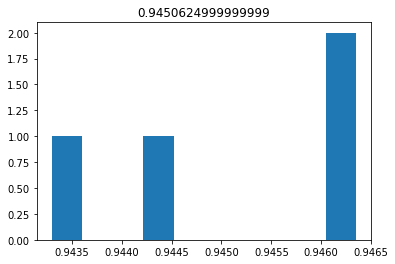

In [127]:
import matplotlib.pyplot as plt
plt.hist([np.mean(cov) for cov in coverage.values()])
plt.title(np.mean([np.mean(cov) for cov in coverage.values()]))
plt.show()

In [60]:
print(list(coverage.keys()))
print([np.mean(cov) for cov in coverage.values()])

['[[0 0]]', '[[0 1]]', '[[1 0]]', '[[1 1]]']
[0.98, 0.95, 0.96, 0.92]


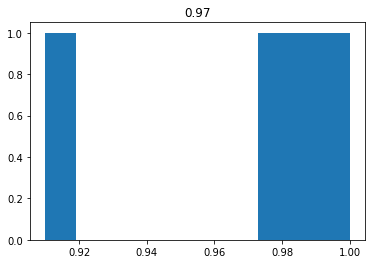

In [61]:
import matplotlib.pyplot as plt
plt.hist([np.mean(cov) for cov in coverage_orig.values()])
plt.title(np.mean([np.mean(cov) for cov in coverage_orig.values()]))
plt.show()

In [358]:
LinearRegression().fit(X, y).coef_

array([1.50031767, 0.04968006, 0.03103112, 0.00223043])

In [340]:
LinearRegression().fit(X, y).intercept_

-0.04184643570696844

In [341]:
LinearRegression().fit(XT_final[:, :-1], y_sum, sample_weight=n_sum).coef_

array([ 1.59675025,  0.15056013,  0.25757637, -0.07023859, -0.00509646,
        0.06998933, -0.0590405 ])

In [342]:
LinearRegression().fit(XT_final[:, :-1], y_sum, sample_weight=n_sum).intercept_

-0.04184643570696889

In [343]:
LinearRegression().fit(XT_final[:first_half, :-1], y_sum[:first_half], sample_weight=n_sum[:first_half]).coef_

array([ 2.04021021, -0.21737653,  0.67455763,  0.01907726,  0.08964679,
        0.13950898, -0.21577723])

In [344]:
LinearRegression().fit(XT_final[:first_half, :-1], y_sum[:first_half], sample_weight=n_sum[:first_half]).intercept_

-0.511629308287567

In [345]:
est._models_y[0]._model.coef_

array([ 2.04021021, -0.21737653,  0.67455763,  0.01907726,  0.08964679,
        0.13950898, -0.21577723])

In [331]:
est._models_y[0]._model.intercept_

0.20229743393835797

In [332]:
from econml.utilities import cross_product, hstack 
cross_product(hstack([X, np.empty((X.shape[0], 0))]),
              hstack([np.ones((X.shape[0], 1)), PolynomialFeatures(degree=1).fit_transform(X), np.empty((X.shape[0], 0))])).shape

(100, 15)

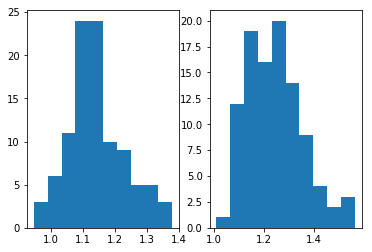

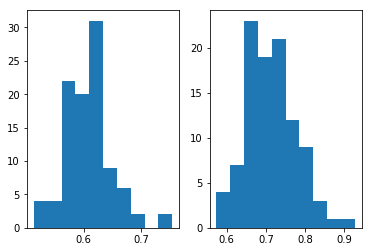

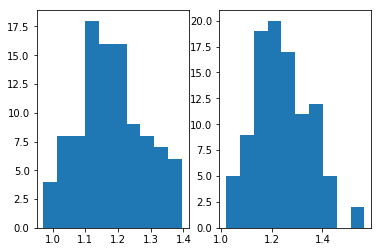

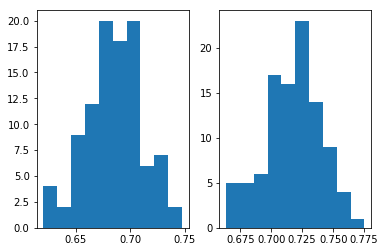

In [39]:
import matplotlib.pyplot as plt
for x, ls in length_orig.items():
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.hist(ls)
    plt.subplot(1, 2, 2)
    plt.hist(length[x])
    plt.show()

In [334]:
from econml.utilities import StatsModelsWrapper
StatsModelsWrapper(fit_intercept=True, fit_args={'cov_type': 'nonrobust'}).fit(XT_final[:, :-1], y_sum, 
                                           sample_weight=n_sum, var_weight=var_sum).stderr_

array([0.21065642, 0.20165538, 0.20234368, 0.20445107])

In [335]:
from econml.utilities import StatsModelsWrapper
StatsModelsWrapper(fit_intercept=True).fit(X, y).stderr_

array([0.21706986, 0.20779478, 0.20850403, 0.21067558])

In [118]:
import numpy as np
from econml.dml import DMLCateEstimator, LinearDMLCateEstimator
from econml.utilities import hstack, StatsModelsWrapperOLD
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV, Lasso, MultiTaskLassoCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold
import scipy.special
import time

np.random.seed(123)
coverage_orig = {}
length_orig = {}
effects_orig = {}
coverage = {}
length = {}
effects = {}
n = 1000
d = 10
d_x = 2
X_test = np.random.binomial(1, .5, size=(100, d_x))
t = time.time()
for it in range(10000):
    
    if it % 50 == 0:
        print("{}: {}".format(it, time.time() - t))
        t = time.time()
        
    X = np.random.binomial(1, .8, size=(n, d))
    T = np.random.binomial(1, .5*X[:, 0]+.25, size=(n,))
    true_effect = lambda x: np.hstack([x[:, [0]] + .5, x[:, [0]] + 1.5])
    y = np.zeros((n, 2))
    y = true_effect(X)*T.reshape(-1,1) + X[:, [0, 0]] + (0*X[:,[0, 0]] + 1)*np.random.normal(0, 1, size=(n,2))

    est = LinearDMLCateEstimator(model_y = MultiTaskLassoCV(alphas=[.001, .01, .1, 1, 10]),
                                 model_t = LassoCV(alphas=[.001, .01, .1, 1, 10]),
                                 n_splits=2,
                                 linear_first_stages=False,
                                 discrete_treatment=False)
    from econml.inference import StatsModelsInference, BootstrapInference
    est.fit(y, T, X[:, :d_x], X[:, d_x:], inference=StatsModelsInference(cov_type='HC0'))
    for x in np.unique(X_test, axis=0):
        x = x.reshape(1, -1)
        eff = est.effect(x)[0]
        eff0, eff1 = est.effect_interval(x, alpha=.05)
        true_eff = true_effect(x.reshape(-1, 1))[0]
        if str(x) in coverage_orig:
            coverage_orig[str(x)].append((eff0[0] <= true_eff) & (eff1[0] >= true_eff))
            length_orig[str(x)].append(eff1[0]-eff0[0])
            effects_orig[str(x)].append(eff)
        else:
            coverage_orig[str(x)] = [(eff0[0] <= true_eff) & (eff1[0] >= true_eff)]
            length_orig[str(x)] = [eff1[0]-eff0[0]]
            effects_orig[str(x)] = [eff]
        #print("{}: {}, ({}, {})".format(x, eff, eff0, eff1))

    # We create two copies per unique X vector and we store the mean and number of half of
    # the data in one copy and mean and number of the other half in the other. If a
    # vector X has only one observation, then we add it at one of the two halfs chosen
    # uniformly at random.
    XT_unique = np.unique(hstack([X, T.reshape(-1,1)]), axis=0)
    y_sum_first = []
    n_sum_first = []
    var_first = []
    XT_final_first = []
    y_sum_sec = []
    n_sum_sec = []
    var_sec = []
    XT_final_sec= []
    for it, xt in enumerate(XT_unique):
        mask = (X==xt[:-1]).all(axis=1) & (T==xt[-1])
        if mask.any():
            y_mask = y[mask]
            if np.sum(mask) >=2:
                y_mask_first = y_mask[:y_mask.shape[0]//2]
                y_mask_sec = y_mask[y_mask.shape[0]//2:]
                y_sum_first.append(np.mean(y_mask_first, axis=0))
                # Alternatively you could also divide the len below by np.var(y_mask_first) if one believes they
                # have heteroskedasticity across segments. Difference in performance is small
                n_sum_first.append(len(y_mask_first))
                var_first.append(np.var(y_mask_first, axis=0))
                XT_final_first.append(xt)
                y_sum_sec.append(np.mean(y_mask_sec, axis=0))
                n_sum_sec.append(len(y_mask_sec))
                var_sec.append(np.var(y_mask_sec, axis=0))
                XT_final_sec.append(xt)
            else:
                if np.random.binomial(1, .5, size=1)==1:
                    y_sum_first.append(np.mean(y_mask, axis=0))
                    n_sum_first.append(len(y_mask))
                    var_first.append(np.var(y_mask, axis=0))
                    XT_final_first.append(xt)
                else:
                    y_sum_sec.append(np.mean(y_mask, axis=0))
                    n_sum_sec.append(len(y_mask))
                    var_sec.append(np.var(y_mask, axis=0))
                    XT_final_sec.append(xt)


    first_half = len(y_sum_first)
    #print("Sizes of two half splits: {}, {}".format(first_half, len(y_sum_sec)))
    y_sum_first.extend(y_sum_sec)
    n_sum_first.extend(n_sum_sec)
    var_first.extend(var_sec)
    XT_final_first.extend(XT_final_sec)
    y_sum = np.array(y_sum_first)
    n_sum = np.array(n_sum_first)
    var_sum = np.array(var_first)
    XT_final = np.array(XT_final_first)

    # Define a custom fold splitter for crossfiting, that returns the two pre-designed splits
    class Splitter:
        def __init__(self):
            return
        def split(self, X, T):
            return [(np.arange(0, first_half), np.arange(first_half, X.shape[0])), 
                    (np.arange(first_half, X.shape[0]), np.arange(0, first_half))]

    # Fit based on the summaries and using the custom splitter
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.linear_model import Lasso
    from econml.utilities import WeightedModelWrapper
    est = LinearDMLCateEstimator(model_y = WeightedModelWrapper(MultiTaskLassoCV(alphas=[.001, .01, .1, 1, 10])),
                                 model_t = WeightedModelWrapper(LassoCV(alphas=[.001, .01, .1, 1, 10])),
                                 n_splits=Splitter(),
                                 linear_first_stages=False,
                                 discrete_treatment=False)
    from econml.inference import StatsModelsInference
    est.fit(y_sum, XT_final[:, -1], XT_final[:, :d_x], XT_final[:, d_x:-1], sample_weight=n_sum, var_weight=var_sum,
            inference=StatsModelsInference(cov_type='HC0'))

    for x in np.unique(X_test, axis=0):
        x = x.reshape(1, -1)
        eff = est.effect(x)[0]
        eff0, eff1 = est.effect_interval(x, alpha=.05)
        true_eff = true_effect(x.reshape(-1, 1))[0]
        if str(x) in coverage:
            coverage[str(x)].append((eff0[0] <= true_eff) & (eff1[0] >= true_eff))
            length[str(x)].append(eff1[0]-eff0[0])
            effects[str(x)].append(eff)
        else:
            coverage[str(x)] = [(eff0[0] <= true_eff) & (eff1[0] >= true_eff)]
            length[str(x)] = [eff1[0]-eff0[0]]
            effects[str(x)] = [eff]
        #print("{}: {}, ({}, {})".format(x, eff, eff0, eff1))
        
print(["{}: {}, {}".format(x, np.mean(cov, axis=0), np.mean(coverage[x], axis=0)) for x, cov in coverage_orig.items()])
print(["{}: {}, {}".format(x, np.median(l, axis=0), np.median(length[x], axis=0)) for x, l in length_orig.items()])

0: 0.0
50: 13.28816294670105
100: 13.307546854019165
150: 15.555468320846558
200: 14.636077880859375
250: 14.908867835998535
300: 14.35831332206726
350: 15.44768476486206
400: 15.619112730026245
450: 12.859241962432861
500: 5.141942024230957
550: 5.029886484146118
600: 5.074988126754761
650: 5.081937074661255
700: 4.987944602966309
750: 5.1899261474609375
800: 5.131896018981934
850: 5.222494602203369
900: 5.363553762435913
950: 5.352933645248413
1000: 5.244940519332886
1050: 5.212929725646973
1100: 5.070939779281616
1150: 5.077934503555298
1200: 5.0659425258636475
1250: 5.164943695068359
1300: 5.213881254196167
1350: 5.3739893436431885
1400: 5.078930616378784
1450: 5.074941635131836
1500: 5.755882263183594
1550: 5.721929311752319
1600: 5.793029069900513
1650: 5.695978879928589
1700: 5.675970792770386
1750: 5.816022634506226
1800: 5.733969688415527
1850: 5.627925634384155
1900: 5.84761905670166
1950: 5.526971340179443
2000: 5.651925325393677
2050: 5.979602575302124
2100: 6.0789661407470

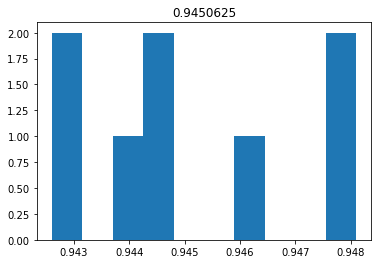

In [122]:
import matplotlib.pyplot as plt
plt.figure()
plt.hist(np.array([np.mean(cov, axis=0) for cov in coverage.values()]).flatten())
plt.title(np.mean([np.mean(cov, axis=0) for cov in coverage.values()]))
plt.show()

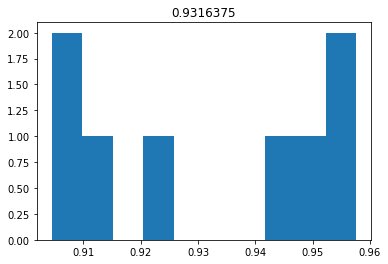

In [123]:
import matplotlib.pyplot as plt
plt.figure()
plt.hist(np.array([np.mean(cov, axis=0) for cov in coverage_orig.values()]).flatten())
plt.title(np.mean([np.mean(cov, axis=0) for cov in coverage_orig.values()]))
plt.show()

In [62]:
from statsmodels.tools.tools import add_constant
from econml.utilities import StatsModelsWrapper

np.random.seed(1235)

n = 3000
d = 3
X = np.random.binomial(1, .8, size=(n, d))
T = np.random.binomial(1, .5*X[:, 0]+.25, size=(n,))
true_effect = lambda x: x[:, 0] + .5
y = np.zeros((n, 2))
y[:, 0] = true_effect(X)*T + X[:, 0] #+ (0*X[:,0] + 1)*np.random.normal(0, 1, size=(n,))
y[:, 1] = (true_effect(X) + 1)*T + X[:, 0] #+ (0*X[:,0] + 1)*np.random.normal(0, 1, size=(n,))
print(LinearRegression().fit(X, y).coef_)
XT_unique = np.unique(X, axis=0)
y_sum_first = []
n_sum_first = []
var_first = []
XT_final_first = []
y_sum_sec = []
n_sum_sec = []
var_sec = []
XT_final_sec= []
for it, xt in enumerate(XT_unique):
    mask = (X==xt).all(axis=1)
    if mask.any():
        y_mask = y[mask]
        if np.sum(mask) >=2:
            y_mask_first = y_mask[:y_mask.shape[0]//2]
            y_mask_sec = y_mask[y_mask.shape[0]//2:]
            y_sum_first.append(np.mean(y_mask_first, axis=0))
            # Alternatively you could also divide the len below by np.var(y_mask_first) if one believes they
            # have heteroskedasticity across segments. Difference in performance is small
            n_sum_first.append(len(y_mask_first))
            var_first.append(np.var(y_mask_first, axis=0))
            XT_final_first.append(xt)
            y_sum_sec.append(np.mean(y_mask_sec, axis=0))
            n_sum_sec.append(len(y_mask_sec))
            var_sec.append(np.var(y_mask_sec, axis=0))
            XT_final_sec.append(xt)
        else:
            if np.random.binomial(1, .5, size=1)==1:
                y_sum_first.append(np.mean(y_mask, axis=0))
                n_sum_first.append(len(y_mask))
                var_first.append(np.var(y_mask, axis=0))
                XT_final_first.append(xt)
            else:
                y_sum_sec.append(np.mean(y_mask, axis=0))
                n_sum_sec.append(len(y_mask))
                var_sec.append(np.var(y_mask, axis=0))
                XT_final_sec.append(xt)


first_half = len(y_sum_first)
#print("Sizes of two half splits: {}, {}".format(first_half, len(y_sum_sec)))
y_sum_first.extend(y_sum_sec)
n_sum_first.extend(n_sum_sec)
var_first.extend(var_sec)
XT_final_first.extend(XT_final_sec)
y_sum = np.array(y_sum_first)
n_sum = np.array(n_sum_first)
var_sum = np.array(var_first)
XT_final = np.array(XT_final_first)
print(n_sum)
print(var_sum.shape)
print(y_sum.shape)
print(y.shape)
OLS = lambda : StatsModelsWrapper(fit_args={'cov_type':'HC0'})
print("Coefs")
print(OLS().fit(X, y).coef_)
print(OLS().fit(XT_final, y_sum, sample_weight=n_sum, var_weight=var_sum).coef_)
print(OLS().fit(XT_final, y_sum).coef_)
print("Intercepts")
print(OLS().fit(X, y).intercept_)
print(OLS().fit(XT_final, y_sum, sample_weight=n_sum, var_weight=var_sum).intercept_)
print(OLS().fit(XT_final, y_sum).intercept_)
#print(OLS().fit(X, y).var_)
#print(OLS().fit(XT_final[:, :-1], y_sum, sample_weight=n_sum, var_weight=var_sum).var_)
print("Param stderrs")
print(OLS().fit(X, y).coef_stderr_)
print(OLS().fit(XT_final, y_sum, sample_weight=n_sum, var_weight=var_sum).coef_stderr_)
print(OLS().fit(XT_final, y_sum).coef_stderr_)
print("Coef interval")
print(OLS().fit(X, y).coef__interval())
print(OLS().fit(XT_final, y_sum, sample_weight=n_sum, var_weight=var_sum).coef__interval())
print(OLS().fit(XT_final, y_sum).coef__interval())
print("Predict stderr")
print(OLS().fit(X, y).prediction_stderr(np.eye(d)))
print(OLS().fit(XT_final, y_sum, sample_weight=n_sum, var_weight=var_sum).prediction_stderr(np.eye(d)))
print("Predict interval")
print(OLS().fit(X, y).predict_interval(np.eye(d)))
print(OLS().fit(XT_final, y_sum, sample_weight=n_sum, var_weight=var_sum).predict_interval(np.eye(d)))

[[ 2.01171874 -0.03434251 -0.01309311]
 [ 2.51741353 -0.05391167 -0.03112553]]
[  7  44  52 191  43 183 188 789   8  45  53 192  44 183 189 789]
(16, 2)
(16, 2)
(3000, 2)
Coefs
[[ 2.01171874 -0.03434251 -0.01309311]
 [ 2.51741353 -0.05391167 -0.03112553]]
[[ 2.01171874 -0.03434251 -0.01309311]
 [ 2.51741353 -0.05391167 -0.03112553]]
[[ 2.00912662 -0.07450833 -0.08024052]
 [ 2.46852671 -0.16340291 -0.20564827]]
Intercepts
[0.16543766 0.44932457]
[0.16543766 0.44932457]
[0.23738766 0.66456531]
Param stderrs
[[0.01585251 0.02669078 0.0266601 ]
 [0.03455591 0.04576888 0.04598392]]
[[0.01585251 0.02669078 0.0266601 ]
 [0.03455591 0.04576888 0.04598392]]
[[0.03281316 0.03281316 0.03281316]
 [0.08375114 0.08375114 0.08375114]]
Coef interval
(array([[ 1.98064839, -0.08665548, -0.06534595],
       [ 2.4496852 , -0.14361703, -0.12125235]]), array([[ 2.01171874, -0.03434251, -0.01309311],
       [ 2.51741353, -0.05391167, -0.03112553]]))
(array([[ 1.98064839, -0.08665548, -0.06534595],
       [ 2

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import econml.stats_models_tests as sm

sm.test1()
sm.test1a()
sm.test1b()
sm.test2()

c:\users\vasy\documents\econml\econml\utilities.py:900: UserWarning: No variance information was given for samples with sample_weight not equal to 1, that represent summaries of multiple original samples. Inference will be invalid!
  warnings.warn("""No variance information was given for samples with sample_weight not equal to 1, that represent summaries of multiple original samples. Inference will be invalid!""")
c:\users\vasy\documents\econml\econml\utilities.py:900: UserWarning: No variance information was given for samples with sample_weight not equal to 1, that represent summaries of multiple original samples. Inference will be invalid!
  warnings.warn("""No variance information was given for samples with sample_weight not equal to 1, that represent summaries of multiple original samples. Inference will be invalid!""")
c:\users\vasy\documents\econml\econml\utilities.py:900: UserWarning: No variance information was given for samples with sample_weight not equal to 1, that represent

Success!
Success!
Success!
Success!


In [8]:
sm.test4()

Success!


In [158]:
from statsmodels.tools.tools import add_constant
np.linalg.pinv(add_constant(X).T @ add_constant(X))

array([[ 0.09375,  0.03125,  0.03125,  0.03125],
       [ 0.03125,  0.34375, -0.15625, -0.15625],
       [ 0.03125, -0.15625,  0.34375, -0.15625],
       [ 0.03125, -0.15625, -0.15625,  0.34375]])

In [59]:
import scipy.stats
scipy.stats.norm.ppf(.05, loc=0, scale=1e-6)

-1.6448536269514728e-06

In [194]:
from econml.utilities import StatsModelsWrapper
StatsModelsWrapper(fit_intercept=False,
                   fit_args={'cov_type':'nonrobust'}).fit(PolynomialFeatures(degree=1).fit_transform(XT_final[:first_half, :-1])\
                                            *(XT_final[:first_half, [-1]] - .5),
                                           y_sum[:first_half] - LinearRegression().fit(XT_final[first_half:, :-1],
                                                                          y_sum[first_half:], 
                                                                         sample_weight=n_sum[first_half:]).predict(XT_final[:first_half, :-1]), 
                                            sample_weight=n_sum[:first_half],
                                            var_weight=None).results.summary()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            WLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.425e+04
Date:                Fri, 13 Sep 2019   Prob (F-statistic):           7.97e-11
Time:                        10:21:28   Log-Likelihood:                 31.599
No. Observations:                   8   AIC:                            -57.20
Df Residuals:                       5   BIC:                            -56.96
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4922      0.007     68.115      0.000       0.474       0.511
x2             1.0058      0.008    120.666      0.000       0.984       1.027
x3             0.0169      0.008      2.030      0.098      -0.005       0.038
==============================================================================
Omnibus:                        0.337   Durbin-Watson:                   0.761
Prob(Omnibus):                  0.845   Jarque-Bera (JB):                0.339
Skew:                           0.343   Prob(JB):                        0.844
Kurtosis:                       2.262   Cond. No.                         3.19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [195]:
from econml.utilities import StatsModelsWrapper
StatsModelsWrapper(fit_intercept=False, fit_args={'cov_type':'HC1'}).fit(PolynomialFeatures(degree=1).fit_transform(X)\
                                            *(T.reshape(-1, 1) - .5),
                                           y - LinearRegression().fit(X, y).predict(X)).results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.239
Model:                            WLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                 1.052e+04
Date:                Fri, 13 Sep 2019   Prob (F-statistic):               0.00
Time:                        10:21:28   Log-Likelihood:            -1.4167e+05
No. Observations:              100000   AIC:                         2.833e+05
Df Residuals:                   99997   BIC:                         2.834e+05
Df Model:                           3                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4861      0.011     44.244      0.000       0.465       0.508
x2             1.0054      0.013     79.660      0.000       0.981       1.030
x3             0.0148      0.013      1.172      0.241      -0.010       0.040
==============================================================================
Omnibus:                        5.348   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.069   Jarque-Bera (JB):                5.249
Skew:                          -0.007   Prob(JB):                       0.0725
Kurtosis:                       2.968   Cond. No.                         3.19
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [196]:
from econml.utilities import StatsModelsWrapper
StatsModelsWrapper(fit_intercept=True).fit(X, y).results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.304
Model:                            WLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                 2.182e+04
Date:                Fri, 13 Sep 2019   Prob (F-statistic):               0.00
Time:                        10:21:28   Log-Likelihood:            -1.5531e+05
No. Observations:              100000   AIC:                         3.106e+05
Df Residuals:                   99997   BIC:                         3.107e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2557      0.006     40.774      0.000       0.243       0.268
x1             1.5111      0.007    208.924      0.000       1.497       1.525
x2            -0.0021      0.007     -0.291      0.771      -0.016       0.012
==============================================================================
Omnibus:                       60.002   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.807
Skew:                          -0.011   Prob(JB):                     2.07e-12
Kurtosis:                       2.889   Cond. No.                         3.19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
import numpy as np
from econml.dml import DMLCateEstimator, LinearDMLCateEstimator
from econml.utilities import hstack
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
import scipy.special

np.random.seed(123)

n = 2000
d = 6
X = np.random.binomial(1, .5, size=(n, d))
T = np.random.binomial(1, scipy.special.expit(2*X[:, 0]-1), size=(n,))
true_effect = lambda x: x[:, 0] + .5
y = true_effect(X)*T + X[:, 0] + (1*X[:,0] + 1)*np.random.normal(0, 1, size=(n,))

est = LinearDMLCateEstimator(model_y = LinearRegression(),
                       model_t = LogisticRegression(solver='lbfgs'), #DummyClassifier(strategy='prior'),
                       n_splits=6,
                       discrete_treatment=True)
from econml.inference import StatsModelsInference
est.fit(y, T, X, None, inference=StatsModelsInference(cov_type='HC1'))
est.effect()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.079
Model:                            WLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     19.82
Date:                Thu, 12 Sep 2019   Prob (F-statistic):           8.00e-26
Time:                        07:24:30   Log-Likelihood:                -3793.9
No. Observations:                2000   AIC:                             7602.
Df Residuals:                    1993   BIC:                             7641.
Df Model:                           7                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.5947      0.200      2.975      0.003       0.203       0.986
x2             0.9006      0.168      5.349      0.000       0.571       1.231
x3             0.0456      0.169      0.270      0.787      -0.286       0.377
x4            -0.2666      0.168     -1.583      0.113      -0.597       0.063
x5             0.2382      0.168      1.421      0.155      -0.090       0.567
x6            -0.0588      0.168     -0.350      0.726      -0.388       0.271
x7            -0.1861      0.169     -1.102      0.270      -0.517       0.145
==============================================================================
Omnibus:                       59.959   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              126.999
Skew:                           0.165   Prob(JB):                     2.65e-28
Kurtosis:                       4.190   Cond. No.                         5.33
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
n = 1000
d = 10
X = np.random.binomial(1, .5, size=(n, d))
T = np.random.binomial(1, .5, size=(n,))
y = (X[:, 0] + .5)*T + X[:, 0] + (0*X[:,0] + 1)*np.random.normal(0, 1, size=(n,))

In [3]:
from econml.bootstrap import BootstrapEstimator
from econml.dml import LinearDMLCateEstimator
est = BootstrapEstimator(LinearDMLCateEstimator(model_y=LinearRegression(), model_t=LinearRegression(),
                             model_final=LinearRegression()),
                         n_bootstrap_samples=1000).fit(y, T, X, None)
est.const_marginal_effect_interval(X[[0]])

NameError: name 'LinearRegression' is not defined

In [107]:
alpha_list = [1, .1, .01, .001, .0001, 1e-5, 1e-6]
contains_zero = []
for alpha in alpha_list:
    marg_effect_interval_lower, marg_effect_interval_higher = est.const_marginal_effect_interval(X[[0]], lower=alpha/2, upper=1-alpha/2)
    print(marg_effect_interval_lower, marg_effect_interval_higher)
    contains_zero.append((marg_effect_interval_lower) <=0 & (marg_effect_interval_higher >=0))

contains_zero = np.array(contains_zero)
# for each const_marginal_effect find the first alpha index at which contains_zero is true
print(contains_zero)
print(np.argwhere(contains_zero))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[0.75183021] [0.75183021]


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[0.59260907] [0.81546581]


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[0.55095803] [0.82237347]


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[0.54679293] [0.82306424]


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[0.54637642] [0.82313331]


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[0.54633477] [0.82314022]
[0.54633061] [0.82314091]
[[False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]]
[]


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished


In [6]:
isinstance(6,int)

True

In [3]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from econml.inference import StatsModelsInference
n = 5000
d = 100
d_x = 4
X = np.random.binomial(1, .5, size=(n, d))
T = np.random.binomial(1, .5, size=(n,)) + np.random.binomial(1, .5, size=(n,))
true_effect = lambda X: (X[:, 0] + X[:, 1] + X[:,0]*X[:,1] + X[:, 2]*X[:, 3] + .5)
y = true_effect(X)*T + X[:, 0] + (0*X[:,0] + 1)*np.random.normal(0, 1, size=(n,))

from econml.dml import DMLCateEstimator, LinearDMLCateEstimator
from sklearn.linear_model import LinearRegression, LassoCV, LogisticRegressionCV
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
est = LinearDMLCateEstimator(model_y = RandomForestRegressor(n_estimators=100, max_depth=5, min_samples_leaf=10), #LassoCV(cv=3),
                             model_t = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_leaf=10), #LogisticRegressionCV(cv=3, solver='lbfgs', multi_class='auto'),
                             featurizer = PolynomialFeatures(degree=2, interaction_only=True),
                             n_splits=6,
                             linear_first_stages=False,
                             discrete_treatment=True)
est.fit(y, T, X[:, :d_x], X[:, d_x:], inference=StatsModelsInference(cov_type='nonrobust'))

In [123]:
from econml.dml import LinearDMLCateEstimator
from sklearn.preprocessing import PolynomialFeatures
from econml.inference import StatsModelsInference
n_products = 3
n_months = 100
# p[i, j] = price of product i on month j
p = np.random.uniform(0, 1, size=(n_products, n_months))
# p_minus[i, j] = average price of products other than i on month j
p_minus = np.zeros(p.shape)
# q[i, j] = demand of product i on month j
q = np.zeros(p.shape)
# X[i, j] = (one-hot-encoding of product i) exludign product 0 used as a baseline
X = np.zeros((n_products, n_months, n_products - 1))
true_effect = lambda X: np.array([([- np.argwhere(x > 0)[0, 0] - 1, - .5 * (np.argwhere(x > 0)[0, 0]+1)]
                                  if len(np.argwhere(x>0)) else [0., 0.]) for x in X])
for i in np.arange(n_products):
    for j in np.arange(n_months):
        p_minus[i, j] = np.mean(p[np.arange(n_products) != i, j])
        q[i, j] = - i * p[i, j] - .5 * i * p_minus[i, j] + np.random.normal(0, .1)
        X[i, j, :] = 1.0 * (np.arange(1, n_products) == i)

# Creating the inputs to the DML method
Y = q.flatten()
T = np.hstack([p.reshape((n_products*n_months, 1)), p_minus.reshape((n_products*n_months, 1))])
X = X.reshape((n_products*n_months, n_products - 1))

from sklearn.linear_model import MultiTaskLassoCV, LassoCV, LinearRegression
est = LinearDMLCateEstimator(model_y = LassoCV(cv=3),
                             model_t = MultiTaskLassoCV(cv=3))
est.fit(Y, T, X, None, inference='statsmodels')
est.const_marginal_effect(np.eye(n_products-1))

array([[-1.00403186, -0.44663968],
       [-2.03912291, -0.98387371]])

In [16]:
from econml.dml import LinearDMLCateEstimator
from sklearn.preprocessing import PolynomialFeatures
from econml.inference import StatsModelsInference
n_products_per_group = 2
n_months = 100
n_groups = 8
n_products = n_groups * n_products_per_group
# p[i, j] = price of product i on month j
p = np.random.uniform(-10, 10, size=(n_products, n_months))
# p_minus[i, j] = average price of products other than i within the same group on month j
p_minus = np.zeros(p.shape)
# q[i, j] = demand of product i on month j
q = np.zeros(p.shape)
# X[i, j] = (one-hot-encoding of product i) exludign product 0 used as a baseline
X = np.zeros((n_products, n_months, n_products + n_months + n_groups - 3))

# Adding some fixed effects on the price of each product
for g in np.arange(n_groups):
    for i in np.arange(n_products_per_group):
        for j in np.arange(n_months):
            index_i = n_products_per_group*g + i
            p[index_i, j] += 3.0*(j==1 or j==2) + 1.0*(j==10)+ 1.0*(index_i==1) + 2.0 * (index_i==10) + 5.0 * (index_i==2)

def true_effect(MX):
    def true_effect_point(x):
        index_i = ((np.argwhere(x > 0)[0, 0] + 1) % n_products_per_group) if np.any(x>0) else 0
        index_g = ((np.argwhere(x > 0)[0, 0] + 1) // n_products_per_group) if np.any(x>0) else 0
        return np.array([- .1 * (index_i + index_g), - .5 * (index_i + index_g)])
    return np.array([true_effect_point(x) for x in MX])

# Creating fake demands
for g in np.arange(n_groups):
    for i in np.arange(n_products_per_group):
        for j in np.arange(n_months):
            index_i = n_products_per_group*g + i
            minus_i = (np.arange(n_products) >= (n_products_per_group*g))
            minus_i &= (np.arange(n_products) < (n_products_per_group*(g+1)))
            minus_i &= (np.arange(n_products) != (index_i))
            p_minus[index_i, j] = np.mean(p[minus_i, j])
            
            X[index_i, j, :(n_products-1)] = 1.0 * (np.arange(1, n_products) == (index_i))
            # adding the one-hot encoding of the month as part of the features of the observation
            X[index_i, j, (n_products-1):(n_products + n_groups - 2)] =  1.0 * (np.arange(1, n_groups) == g)
            X[index_i, j, (n_products + n_groups - 2):] = 1.0 * (np.arange(1, n_months) == j)
            
            eff = true_effect(X[[index_i], j, :(n_products-1)])[0]
            q[index_i, j] = eff[0] * p[index_i, j] + eff[1] * p_minus[index_i, j] + np.random.normal(0, 1)
            # adding some fixed effects on the demand
            q[index_i, j] += 3.0 * (j==1 or j==2) + 5.0*(index_i==1) + 5.0*(index_i==10) + 5.0 * (index_i==2)


# Creating the inputs to the DML method
Y = q.flatten()
T = np.hstack([p.reshape((n_products*n_months, 1)), p_minus.reshape((n_products*n_months, 1))])
X = X.reshape((n_products*n_months, n_products + n_months + n_groups - 3))

fold0 = np.empty((0,))
for i in np.arange(n_products//2):
    fold0 = np.concatenate((fold0, np.arange(i*n_months, i*n_months + n_months//2)))
for i in np.arange(n_products//2, n_products):
    fold0 = np.concatenate((fold0, np.arange(i*n_months + n_months//2, (i+1)*n_months)))
fold1 = np.setdiff1d(np.arange(n_products*n_months), fold0).astype(int)
fold0 = fold0.astype(int)

fold00 = np.empty((0,))
for i in np.arange(n_products//4):
    fold00 = np.concatenate((fold00, np.arange(i*(n_months//2), i*(n_months//2) + n_months//4)))
for i in np.arange(n_products//4, n_products//2):
    fold00 = np.concatenate((fold00, np.arange(i*(n_months//2) + (n_months//4), (i+1)*(n_months//2))))
for i in np.arange(n_products//2, 3*n_products//4):
    fold00 = np.concatenate((fold00, np.arange(i*(n_months//2), i*(n_months//2) + n_months//4)))
for i in np.arange(3*n_products//4, n_products):
    fold00 = np.concatenate((fold00, np.arange(i*(n_months//2) + (n_months//4), (i+1)*(n_months//2))))
fold11 = np.setdiff1d(np.arange((n_products)*(n_months//2)), fold00).astype(int)
fold00 = fold00.astype(int)

from sklearn.linear_model import MultiTaskLassoCV, LassoCV, LinearRegression, Lasso, MultiTaskLasso
# Set linear_first_stages to false because this creates extra expanded features of the form X cross W 
# that slows code down. Effect on correctness is small. For full correctness it must be set to True
# if linear models are used as first stage models. You can set to False if for instance Random Forests
# are used as first stages.
from econml.dml import SparseLinearDMLCateEstimator
from econml.utilities import MultiModelWrapper
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.base import clone
class MultiTask:
    def __init__(self, model):
        self.model = clone(model, safe=False)
    def fit(self, X, y):
        self.models = []
        for it in range(y.shape[1]):
            self.models.append(clone(self.model).fit(X, y[:, it]))
    def predict(self, X):
        return np.hstack([mdl.predict(X).reshape(-1, 1) for mdl in self.models])
est = LinearDMLCateEstimator(model_y = LassoCV(cv=6), #[(fold00, fold11), (fold11, fold00)]),
                             model_t = MultiTaskLassoCV(cv=6), #[(fold00, fold11), (fold11, fold00)]),
                             n_splits = 6, #[(fold0, fold1), (fold1, fold0)],
                             linear_first_stages=False)
# Using the one-hot encondings of the products as X and the one-hot encodings of the month as W
# to control for time fixed effects
est.fit(Y, T, X[:, :(n_products - 1)],  X[:, (n_products - 1):], inference='statsmodels')

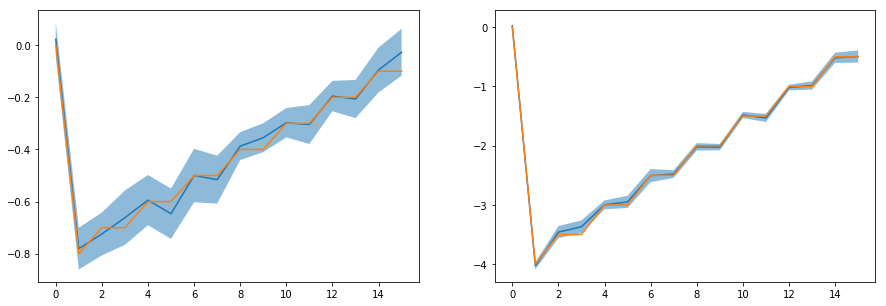

In [17]:
import matplotlib.pyplot as plt
X = np.unique(X[:, :(n_products - 1)], axis=0) #np.vstack([np.zeros((1,n_products-1)), np.eye(n_products-1)])
l, h = est.const_marginal_effect_interval(X, alpha=0.01)
p = est.const_marginal_effect(X)
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(p[:, 0])
plt.fill_between(np.arange(X.shape[0]), l[:,0], h[:,0], alpha=.5)
plt.plot(true_effect(X)[:,0])
plt.subplot(1,2,2)
plt.plot(p[:, 1])
plt.fill_between(np.arange(X.shape[0]), l[:,1], h[:,1], alpha=.5)
plt.plot(true_effect(X)[:,1])
plt.show()

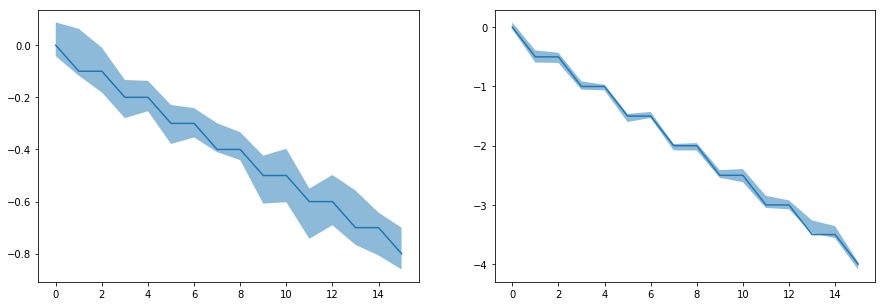

[['0' '[-0. -0.]' '[-0.042 -0.032]' '[0.088 0.083]' '[ True  True]']
 ['1' '[-0.1 -0.5]' '[-0.117 -0.597]' '[ 0.063 -0.391]' '[ True  True]']
 ['2' '[-0.1 -0.5]' '[-0.181 -0.602]' '[-0.009 -0.43 ]' '[ True  True]']
 ['3' '[-0.2 -1. ]' '[-0.28  -1.053]' '[-0.134 -0.914]' '[ True  True]']
 ['4' '[-0.2 -1. ]' '[-0.253 -1.066]' '[-0.137 -0.971]' '[ True  True]']
 ['5' '[-0.3 -1.5]' '[-0.379 -1.6  ]' '[-0.23  -1.463]' '[ True  True]']
 ['6' '[-0.3 -1.5]' '[-0.354 -1.533]' '[-0.241 -1.43 ]' '[ True  True]']
 ['7' '[-0.4 -2. ]' '[-0.41  -2.078]' '[-0.299 -1.971]' '[ True  True]']
 ['8' '[-0.4 -2. ]' '[-0.441 -2.081]' '[-0.334 -1.956]' '[ True  True]']
 ['9' '[-0.5 -2.5]' '[-0.608 -2.543]' '[-0.424 -2.413]' '[ True  True]']
 ['10' '[-0.5 -2.5]' '[-0.602 -2.616]' '[-0.398 -2.395]' '[ True  True]']
 ['11' '[-0.6 -3. ]' '[-0.743 -3.052]' '[-0.55  -2.845]' '[ True  True]']
 ['12' '[-0.6 -3. ]' '[-0.691 -3.073]' '[-0.498 -2.923]' '[ True  True]']
 ['13' '[-0.7 -3.5]' '[-0.766 -3.476]' '[-0.558 -3.2

In [18]:
import matplotlib.pyplot as plt
X = np.vstack([np.zeros((1,n_products-1)), np.eye(n_products-1)])
l, h = est.const_marginal_effect_interval(X, alpha=0.01)
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.fill_between(np.arange(X.shape[0]), l[:,0], h[:,0], alpha=.5)
plt.plot(true_effect(X)[:,0])
plt.subplot(1,2,2)
plt.fill_between(np.arange(X.shape[0]), l[:,1], h[:,1], alpha=.5)
plt.plot(true_effect(X)[:,1])
plt.show()
with np.printoptions(precision=3, suppress=True):
    print(np.array([("{}".format(np.argwhere(n>0)[0,0]+1 if np.any(n>0) else 0),
                     "{}".format(t), "{}".format(l), "{}".format(h),
                     "{}".format(((t<=h) & (t>=l))))
                    for n,l,h,t in zip(X,
                                     *est.const_marginal_effect_interval(X, alpha=0.01),
                                                true_effect(X))]))


In [5]:
from econml.dml import LinearDMLCateEstimator
from sklearn.preprocessing import PolynomialFeatures
from econml.inference import StatsModelsInference
n_products = 3
n_months = 12
# p[i, j] = price of product i on month j
p = np.random.uniform(0, 1, size=(n_products, n_months))
# p_minus[i, j] = average price of products other than i on month j
p_minus = np.zeros(p.shape)
# q[i, j] = demand of product i on month j
q = np.zeros(p.shape)

for i in np.arange(n_products):
    for j in np.arange(n_months):
        p_minus[i, j] = np.mean(p[np.arange(n_products) != i, j])
        q[i, j] = - i * p[i, j] - .5 * i * p_minus[i, j] + np.random.normal(0, .1)

est = LinearDMLCateEstimator(model_y = MultiTaskLasso(alpha=0.01),
                             model_t = MultiTaskLasso(alpha=0.01),
                             n_splits = 2,
                             linear_first_stages=False)
est.fit(q.T, p.T, inference='statsmodels')
with np.printoptions(precision=3, suppress=True):
    p = est.const_marginal_effect()[0]
    l, u = est.const_marginal_effect_interval()
    arr = np.stack((p, l[0],u[0]), axis=-1)
    print(np.array(["{:.2f} ({:.2f}, {:.2f})".format(arr[i,j,0], arr[i,j,1], arr[i,j,2])
                    for i in range(arr.shape[0]) for j in range(arr.shape[1])]).reshape(l[0].shape))

[['-0.19 (-0.41, 0.04)' '0.10 (-0.15, 0.36)' '-0.18 (-0.41, 0.05)']
 ['-0.30 (-0.46, -0.14)' '-0.59 (-0.84, -0.33)' '-0.17 (-0.30, -0.03)']
 ['-0.43 (-0.68, -0.18)' '-0.73 (-0.97, -0.50)' '-1.80 (-2.01, -1.60)']]


c:\users\vasy\documents\econml\econml\utilities.py:1133: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-variance matrix is undertermined. Inference will be invalid!")


In [280]:
with np.printoptions(precision=3, suppress=True):
    print(np.array([(n, "{:.3f}".format(l), "{:.3f}".format(h),
                     "***" if (l3>0 or h3<0) else ("**" if (l2>0 or h2<0) else ("*" if (l>0 or h<0) else "")))
                    for n,l,h,l2,h2,l3,h3 in zip(list(est.featurizer.get_feature_names())*len(np.unique(T)),
                                     *est.coef__interval(alpha=0.05),
                                     *est.coef__interval(alpha=0.005),
                                     *est.coef__interval(alpha=0.0005),
                                                )]))

TypeError: unsupported format string passed to numpy.ndarray.__format__

In [281]:
est.coef__interval()

(array([[-0.10635112, -0.10635112, -0.02576807, -0.02576807,  0.00233149,
          0.00233149],
        [-0.43807177, -0.43807177, -0.57117776, -0.57117776, -0.16978544,
         -0.16978544],
        [-0.36703447, -0.36703447, -0.50504013, -0.50504013, -1.13052763,
         -1.13052763]]),
 array([[ 0.02514889,  0.02514889,  0.12194052,  0.12194052,  0.1477013 ,
          0.1477013 ],
        [-0.08485031, -0.08485031, -0.33717583, -0.33717583,  0.02172222,
          0.02172222],
        [-0.17208381, -0.17208381, -0.22518778, -0.22518778, -0.92865114,
         -0.92865114]]))

In [21]:
import matplotlib.pyplot as plt
plt.hist(est.effect(X[:, :d_x]))
plt.show()

ValueError: could not broadcast input array from shape (2000,56) into shape (2000)

In [135]:
import sklearn
from sklearn.tree import DecisionTreeRegressor
y0, y1 = est.effect_interval(X[:, :d_x])
y_pred = est.effect(X[:, :d_x])
reg = DecisionTreeRegressor(max_depth=4, min_impurity_decrease=.001).fit(X, np.hstack([y0.reshape(-1,1), y_pred.reshape(-1,1), y1.reshape(-1,1)]))
sklearn.tree.export_graphviz(reg, 'test.dot')

In [50]:
import sklearn
from sklearn.tree import DecisionTreeClassifier
y0, y1 = est.effect_interval(X[:, :d_x])
y_pred = est.effect(X[:, :d_x])
cost = .5
label = y0 - cost
reg = DecisionTreeClassifier(max_depth=3).fit(X, np.sign(label), sample_weight=np.abs(label))
sklearn.tree.export_graphviz(reg, 'test.dot')

In [109]:
from econml.metalearners import DoublyRobustLearner, LinearDoublyRobustLearner
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
n = 600
d = 10
d_x = 4
X = np.random.binomial(1, .5, size=(n, d))
T = np.random.binomial(1, .5, size=(n,))
y = (X[:, 0] + X[:, 1] + X[:,0]*X[:,1] + X[:, 2]*X[:, 3] + .5)*T + X[:, 0] + (0*X[:,0] + 1)*np.random.normal(0, 1, size=(n,))

from econml.dml import DMLCateEstimator, LinearDMLCateEstimator
from sklearn.linear_model import LinearRegression, LassoCV, LogisticRegressionCV
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
est = LinearDoublyRobustLearner(outcome_model = RandomForestRegressor(n_estimators=1000, max_depth=5, min_samples_leaf=10),
                                propensity_model = RandomForestClassifier(n_estimators=1000, max_depth=5, min_samples_leaf=10),
                                featurizer=PolynomialFeatures(degree=2, include_bias=False, interaction_only=True))
from econml.inference import StatsModelsInference
est.fit(y, T, X[:, :d_x], X[:, d_x:], inference=StatsModelsInference(cov_type='nonrobust'))

In [110]:
with np.printoptions(precision=3, suppress=True):
    print(est.coef_)

[ 1.207  1.497 -0.204 -0.011  0.802  0.289 -0.148 -0.321  0.119  0.753]


In [111]:
est.intercept_

0.36485182866608434

In [112]:
est.intercept__interval(alpha=.01)

(-0.35830400693228615, 1.0880076642644547)

In [113]:
est.const_marginal_effect_interval(X[:3, :d_x])

(array([ 1.52733627, -0.09693556,  1.44760728]),
 array([2.41080564, 0.82663922, 2.275475  ]))

In [114]:
est.coef__interval(alpha=0.01)

(array([ 0.34041142,  0.66833843, -1.04120538, -0.86345052, -0.03416916,
        -0.54630646, -0.98444786, -1.15393147, -0.71782823, -0.0805297 ]),
 array([2.07282093, 2.32504018, 0.63419183, 0.84071604, 1.638624  ,
        1.12417823, 0.6892978 , 0.51209052, 0.95562236, 1.58734827]))

In [117]:
with np.printoptions(precision=3, suppress=True):
    print(np.array([(n, "{:.3f}".format(l), "{:.3f}".format(h),
                     "***" if (l3>0 or h3<0) else ("**" if (l2>0 or h2<0) else ("*" if (l>0 or h<0) else "")))
                    for n,l,h,l2,h2,l3,h3 in zip(est._featurizer.get_feature_names(),
                                     *est.coef__interval(alpha=0.05),
                                     *est.coef__interval(alpha=0.005),
                                     *est.coef__interval(alpha=0.0005))]))

[['x0' '0.548' '1.866' '***']
 ['x1' '0.866' '2.127' '***']
 ['x2' '-0.841' '0.434' '']
 ['x3' '-0.660' '0.637' '']
 ['x0 x1' '0.166' '1.439' '*']
 ['x0 x2' '-0.347' '0.924' '']
 ['x0 x3' '-0.784' '0.489' '']
 ['x1 x2' '-0.955' '0.313' '']
 ['x1 x3' '-0.518' '0.756' '']
 ['x2 x3' '0.119' '1.388' '*']]


In [80]:
est._inference.featurizer

In [39]:
feats = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
print(feats.fit_transform(feats.fit_transform(X[:3])).shape)

KeyboardInterrupt: 

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.utils.metaestimators import if_delegate_has_method
from econml.utilities import StatsModelsLinearRegression
class InferencePipeline(Pipeline):
    def __init__(self, steps, memory=None):
        super().__init__(steps, memory=memory)
        
    @if_delegate_has_method(delegate='_final_estimator')
    def predict_interval(self, X, **predict_params):
        Xt = X
        for name, transform in self.steps[:-1]:
            if transform is not None:
                Xt = transform.transform(Xt)
        return self.steps[-1][-1].predict_interval(Xt, **predict_params)
    @if_delegate_has_method(delegate='_final_estimator')
    def coef__interval(self, **predict_params):
        return self.steps[-1][-1].coef__interval(**predict_params)
est = InferencePipeline([('pre', PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)),
                ('last', StatsModelsLinearRegression())])
est.fit(X[:, :3], y)
print(est.predict_interval(X[:3, :3]))
print(est.coef__interval(alpha=.05))

(array([0.54459464, 1.58964207, 0.54459464]), array([0.89644765, 1.94208466, 0.89644765]))
(array([ 1.28442609,  0.23922527,  0.02483883,  0.25110661, -0.29117647,
       -0.22157358]), array([1.75605661, 0.71057299, 0.49534695, 0.79067504, 0.24854367,
       0.31814219]))


In [124]:
import sklearn
from sklearn.tree import DecisionTreeRegressor
y_pred = est.effect(X[:, :d_x])
reg = DecisionTreeRegressor(max_depth=4, min_impurity_decrease=.001).fit(X, y_pred)
sklearn.tree.export_graphviz(reg, 'test.dot')

In [75]:
print(reg.predict(X))

[[3.18130058 3.42745829 3.67361599]
 [2.26401888 2.51059395 2.75716903]
 [4.17583975 4.42397189 4.67210402]
 ...
 [3.18130058 3.42745829 3.67361599]
 [1.30998187 1.55562102 1.80126018]
 [3.18130058 3.42745829 3.67361599]]


In [13]:
from econml.dml import DMLCateEstimator,SparseLinearDMLCateEstimator  
from econml.utilities import hstack
# We create two copies per unique X vector and we store the mean and number of half of
# the data in one copy and mean and number of the other half in the other. If a
# vector X has only one observation, then we add it at one of the two halfs chosen
# uniformly at random.
XT_unique = np.unique(hstack([X, T.reshape(-1,1)]), axis=0)
y_sum_first = []
n_sum_first = []
XT_final_first = []
y_sum_sec = []
n_sum_sec = []
XT_final_sec= []
for it, xt in enumerate(XT_unique):
    mask = (X==xt[:-1]).all(axis=1) & (T==xt[-1])
    if mask.any():
        y_mask = y[mask]
        if np.sum(mask) >=2:
            y_mask_first = y_mask[:y_mask.shape[0]//2]
            y_mask_sec = y_mask[y_mask.shape[0]//2:]
            y_sum_first.append(np.mean(y_mask_first))
            n_sum_first.append(len(y_mask_first))
            XT_final_first.append(xt)
            y_sum_sec.append(np.mean(y_mask_sec))
            n_sum_sec.append(len(y_mask_sec))
            XT_final_sec.append(xt)
        else:
            if np.random.binomial(1, .5, size=1)==1:
                y_sum_first.append(np.mean(y_mask))
                n_sum_first.append(len(y_mask))
                XT_final_first.append(xt)
            else:
                y_sum_sec.append(np.mean(y_mask))
                n_sum_sec.append(len(y_mask))
                XT_final_sec.append(xt)
            

first_half = len(y_sum_first)
print(first_half)
print(len(y_sum_sec))
y_sum_first.extend(y_sum_sec)
n_sum_first.extend(n_sum_sec)
XT_final_first.extend(XT_final_sec)
y_sum = np.array(y_sum_first)
n_sum = np.array(n_sum_first)
XT_final = np.array(XT_final_first)


class Splitter:
    def __init__(self):
        return
    def split(self, Y, T, X, W, sample_weight):
        return [(np.arange(0, first_half), np.arange(first_half, Y.shape[0])), 
                (np.arange(first_half, Y.shape[0]), np.arange(0, first_half))]

est = LinearDMLCateEstimator(model_y = LinearRegression(),
                       model_t = DummyClassifier(strategy='prior'),
                       n_splits=Splitter(),
                       discrete_treatment=True)
from econml.inference import StatsModelsInference
est.fit(y_sum, XT_final[:, -1], XT_final[:, :-1], None, sample_weight=n_sum,
        inference=StatsModelsInference(cov_type='HC1'))
est._model_final._model.results.summary()

9987
10013


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.225
Model:                            WLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     276.5
Date:                Mon, 09 Sep 2019   Prob (F-statistic):               0.00
Time:                        04:20:56   Log-Likelihood:                -28795.
No. Observations:               20000   AIC:                         5.763e+04
Df Residuals:                   19979   BIC:                         5.780e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.5874      0.066      8.893      0.000       0.458       0.717
x2             0.9590      0.029     33.177      0.000       0.902       1.016
x3            -0.0309      0.029     -1.070      0.285      -0.088       0.026
x4             0.0102      0.029      0.351      0.725      -0.047       0.067
x5             0.0050      0.029      0.171      0.864      -0.052       0.062
x6            -0.0130      0.029     -0.451      0.652      -0.070       0.044
x7            -0.0404      0.029     -1.396      0.163      -0.097       0.016
x8            -0.0063      0.029     -0.217      0.828      -0.063       0.050
x9             0.0067      0.029      0.232      0.816      -0.050       0.063
x10           -0.0093      0.029     -0.323      0.747      -0.066       0.047
x11            0.0417      0.029      1.442      0.149      -0.015       0.098
x12            0.0318      0.029      1.101      0.271      -0.025       0.088
x13           -0.0352      0.029     -1.218      0.223      -0.092       0.021
x14           -0.0262      0.029     -0.906      0.365      -0.083       0.030
x15            0.0029      0.029      0.102      0.919      -0.054       0.060
x16           -0.0518      0.029     -1.791      0.073      -0.108       0.005
x17            0.0025      0.029      0.086      0.931      -0.054       0.059
x18           -0.0065      0.029     -0.224      0.822      -0.063       0.050
x19           -0.0359      0.029     -1.243      0.214      -0.093       0.021
x20           -0.0403      0.029     -1.395      0.163      -0.097       0.016
x21            0.0477      0.029      1.649      0.099      -0.009       0.104
==============================================================================
Omnibus:                        4.196   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.123   Jarque-Bera (JB):                4.202
Skew:                           0.027   Prob(JB):                        0.122
Kurtosis:                       3.046   Cond. No.                         12.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
from econml.dml import DMLCateEstimator,SparseLinearDMLCateEstimator  
from econml.utilities import hstack
XT_unique = np.unique(hstack([X, T.reshape(-1,1)]), axis=0)
y_sum = []
n_sum = []
XT_final = []
for it, xt in enumerate(XT_unique):
    mask = (X==xt[:-1]).all(axis=1) & (T==xt[-1])
    if mask.any():
        y_mask = y[mask]
        y_sum.append(np.mean(y_mask))
        n_sum.append(len(y_mask))
        XT_final.append(xt)

y_sum = np.array(y_sum)
n_sum = np.array(n_sum)
XT_final = np.array(XT_final)


est = LinearDMLCateEstimator(model_y = LinearRegression(),
                       model_t = DummyClassifier(strategy='prior'),
                       n_splits=2,
                       discrete_treatment=True)
est.fit(y_sum, XT_final[:, -1], XT_final[:, :-1], None, sample_weight=n_sum, inference='statsmodels')
est._model_final._model.results.summary()

In [56]:
for it, xt in enumerate(XT_unique):

SyntaxError: unexpected EOF while parsing (<ipython-input-56-2ee7aae62dc0>, line 1)

In [14]:
est.coef_

array([ 0.66710921,  1.1194121 ,  0.13423844, -0.01444813,  0.04282233,
       -0.16701646, -0.3538747 , -0.08366747,  0.54372055,  0.34446801,
       -0.51488198])

In [130]:
from econml.utilities import StatsModelLinearRegression

est = StatsModelLinearRegression(cov_type='HC1')
est.fit(X, y)
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.197
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     490.3
Date:                Sat, 22 Jun 2019   Prob (F-statistic):               0.00
Time:                        18:35:49   Log-Likelihood:                -14288.
No. Observations:               10000   AIC:                         2.859e+04
Df Residuals:                    9994   BIC:                         2.863e+04
Df Model:                           5                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0072      0.024     -0.296      0.768      -0.055       0.041
x1             0.9995      0.020     49.472      0.000       0.960       1.039
x2             0.0024      0.020      0.118      0.906      -0.037       0.042
x3             0.0140      0.020      0.693      0.488      -0.026       0.054
x4             0.0145      0.020      0.716      0.474      -0.025       0.054
x5            -0.0069      0.020     -0.340      0.734      -0.046       0.033
==============================================================================
Omnibus:                        0.546   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.761   Jarque-Bera (JB):                0.568
Skew:                           0.016   Prob(JB):                        0.753
Kurtosis:                       2.983   Cond. No.                         4.82
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [15]:
from econml.utilities import StatsModelLinearRegression

X_unique = np.unique(X, axis=0)
y_sum = np.zeros(X_unique.shape[0])
n_sum = np.zeros(X_unique.shape[0])
for it, x in enumerate(X_unique):
    y_sum[it] = np.mean(y[(X==x).all(axis=1)])
    n_sum[it] = np.sum((X==x).all(axis=1))

est = StatsModelLinearRegression(cov_type='HC1')
est.fit(X_unique, y_sum, sample_weight=n_sum/X.shape[0])
est.summary()

ImportError: cannot import name 'StatsModelLinearRegression' from 'econml.utilities' (c:\users\vasy\documents\econml\econml\utilities.py)

In [89]:
X_unique = np.unique(X, axis=0)
print(X_unique.shape)
for x in X_unique:
    print(x)
    print(X)
    print((X==x).all(axis=1))

(4, 2)
[0 0]
[[0 0]
 [1 0]
 [0 0]
 [1 1]
 [0 0]
 [0 1]
 [0 1]
 [0 0]
 [1 0]
 [1 0]]
[ True False  True False  True False False  True False False]
[0 1]
[[0 0]
 [1 0]
 [0 0]
 [1 1]
 [0 0]
 [0 1]
 [0 1]
 [0 0]
 [1 0]
 [1 0]]
[False False False False False  True  True False False False]
[1 0]
[[0 0]
 [1 0]
 [0 0]
 [1 1]
 [0 0]
 [0 1]
 [0 1]
 [0 0]
 [1 0]
 [1 0]]
[False  True False False False False False False  True  True]
[1 1]
[[0 0]
 [1 0]
 [0 0]
 [1 1]
 [0 0]
 [0 1]
 [0 1]
 [0 0]
 [1 0]
 [1 0]]
[False False False  True False False False False False False]


## 1. Example Usage with Single Continuous Treatment Synthetic Data

### 1.1. DGP 
We use the data generating process (DGP) from [here](https://arxiv.org/abs/1806.03467). The DGP is described by the following equations:

\begin{align}
T =& \langle W, \beta\rangle + \eta, & \;\eta \sim \text{Uniform}(-1, 1)\\
Y =& T\cdot \theta(X) + \langle W, \gamma\rangle + \epsilon, &\; \epsilon \sim \text{Uniform}(-1, 1)\\
W \sim& \text{Normal}(0,\, I_{n_w})\\
X \sim& \text{Uniform}(0,1)^{n_x}
\end{align}

where $W$ is a matrix of high-dimensional confounders and $\beta, \gamma$ have high sparsity.

For this DGP, 
\begin{align}
\theta(x) = \exp(2\cdot x_1).
\end{align}

In [5]:
# Treatment effect function
def exp_te(x):
    return x[0]**2 #4*(x[0]*(x[0]<.25) + (.25 - .2*x[0])*((x[0]>=.25) & (x[0]<.75)) + x[0]*(x[0]>=.75)) #np.exp(2*x[0])

In [31]:
# DGP constants
n=10000
n_w=10
support_size=5
n_x=2
def dgp(random_state=123):
    np.random.seed(random_state)
    # Outcome support
    support_Y=np.random.choice(range(n_w),size=support_size,replace=False)
    coefs_Y=np.random.uniform(0,1,size=support_size)
    epsilon_sample=lambda n: np.random.uniform(-1,1,size=n)
    # Treatment support
    support_T=support_Y
    coefs_T=np.random.uniform(0,1,size=support_size)
    eta_sample=lambda n: np.random.uniform(-.5,.5,size=n)

    # Generate controls, covariates, treatments and outcomes
    W=np.random.normal(0,1,size=(n,n_w))
    X=np.random.uniform(0,1,size=(n,n_x))
    # Heterogeneous treatment effects
    TE=np.array([exp_te(x_i) for x_i in X])
    T=np.dot(W[:,support_T],coefs_T)+eta_sample(n)
    Y=TE*T+np.dot(W[:,support_Y],coefs_Y)+epsilon_sample(n)
    return Y, T, X, W
Y, T, X, W = dgp()

In [32]:
# Generate test data
X_test = np.tile(np.arange(0, 1, 0.01).reshape(-1,1), (1, n_x))

In [33]:
X_test.shape

(100, 2)

In [34]:
from xgboost import XGBClassifier, XGBRegressor
from econml.xgb_utilities import XGBWrapper


# Define a generic non-parametric regressor
#model = lambda: GradientBoostingRegressor(n_estimators=20, max_depth=3, min_samples_leaf=20,
#                                         n_iter_no_change=5, min_impurity_decrease=.001, tol=0.001)
model = lambda: XGBWrapper(XGBRegressor(gamma=0.001, n_estimators=100, min_child_weight=5, n_jobs=10),
                           early_stopping_rounds=5, eval_metric='rmse', binary=False)

### 1.2. Train Estimator
We train models in three different ways, and compare their performance.


#### 1.2.1. Default Setting

In [35]:
est = DMLCateEstimator(model_y=model(),
                       model_t=model(),
                       n_splits=2,
                       random_state=123)
est.fit(Y, T, X, W)
te_pred = est.effect(X_test)

#### 1.2.2. Polynomial Features for Heterogeneity

In [36]:
est1 = DMLCateEstimator(model_y=model(),
                        model_t=model(),
                        model_final=Lasso(alpha=0.001),
                        featurizer=PolynomialFeatures(degree=2, interaction_only=False),
                        n_splits=2,
                        random_state=123)
est1.fit(Y, T, X, W)
te_pred1=est1.effect(X_test)

#### 1.2.3. Polynomial Features with regularization 

In [ ]:
from econml.dml import GenericDMLCateEstimator, ForestDMLCateEstimator
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

est2 = ForestDMLCateEstimator(model_y=model(),
                              model_t=model(),
                              n_estimators=1000, min_samples_leaf=5,
                              min_weight_fraction_leaf=.00,
                              max_depth=10,
                              honest=True,
                              global_averaging=False,
                              n_crossfit_splits=6,
                              random_state=123)
est2.fit(Y, T, X, W)
te_pred2=est2.effect(X_test)

In [51]:
lower, upper = est2.effect_interval(X_test, lower=1, upper=99, normal=False)

In [39]:
import scipy
scipy.stats.norm.ppf(.9, loc=[1,2])

array([2.28155157, 3.28155157])

In [ ]:
from econml.dml import GenericDMLCateEstimator
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

est2 = GenericDMLCateEstimator(model_y=model(),
                               model_t=model(),
                               model_final=GradientBoostingRegressor(n_iter_no_change=5, n_estimators=50,
                                                                     min_samples_leaf=10,
                                                                     max_depth=3),
                               n_splits=6,
                               random_state=123)
est2.fit(Y, T, X, W)
te_pred2=est2.effect(X_test)

In [ ]:
from econml.ortho_forest import ContinuousTreatmentOrthoForest
from econml.utilities import WeightedModelWrapper
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

est2 = ContinuousTreatmentOrthoForest(model_T=WeightedModelWrapper(Lasso(alpha=0.01)),
                 model_Y=WeightedModelWrapper(Lasso(alpha=0.01)),
                 model_T_final=WeightedModelWrapper(LassoCV(cv=3)),
                 model_Y_final=WeightedModelWrapper(LassoCV(cv=3)),
                 n_trees=100, min_leaf_size=10, subsample_ratio=.99)
est2.fit(Y, T.flatten(), X, W)

In [ ]:
te_pred2, lower, upper = est2.const_marginal_effect(X_test, interval=True)

### 1.3. Performance Visualization

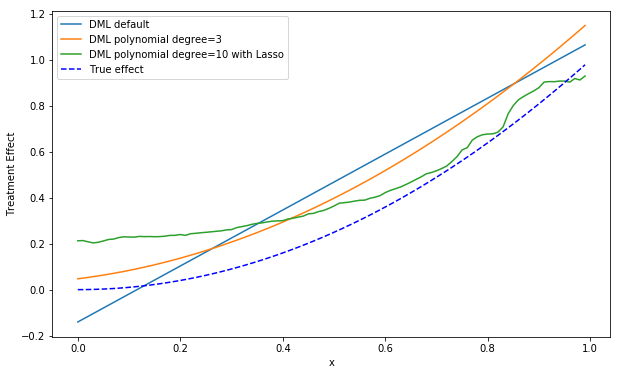

In [52]:
plt.figure(figsize=(10,6))
plt.plot(X_test[:,0], te_pred,label='DML default')
plt.plot(X_test[:,0], te_pred1,label='DML polynomial degree=3')
plt.plot(X_test[:,0], te_pred2,label='DML polynomial degree=10 with Lasso')
expected_te=np.array([exp_te(x_i) for x_i in X_test])
plt.plot(X_test[:,0], expected_te,'b--',label='True effect')
plt.ylabel('Treatment Effect')
plt.xlabel('x')
plt.legend()
plt.show()

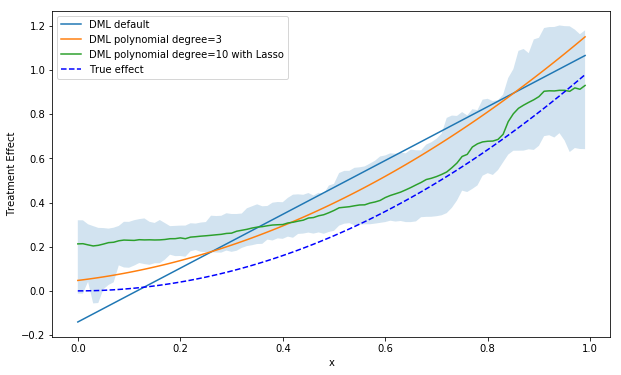

In [53]:
plt.figure(figsize=(10,6))
plt.plot(X_test[:,0], te_pred, label='DML default')
plt.plot(X_test[:,0], te_pred1, label='DML polynomial degree=3')
plt.plot(X_test[:,0], te_pred2, label='DML polynomial degree=10 with Lasso')
plt.fill_between(X_test[:,0], lower, upper, alpha=.2)
expected_te=np.array([exp_te(x_i) for x_i in X_test])
plt.plot(X_test[:,0], expected_te,'b--',label='True effect')
plt.ylabel('Treatment Effect')
plt.xlabel('x')
plt.legend()
plt.show()

In [54]:
print(est2._model_final._model.subsample_fr)

0.24182711751219582


In [55]:
print(np.mean((lower <expected_te) & (upper>expected_te)))

0.49


In [ ]:
est2._model_final._model.estimators_[0].tree_.children_left

In [ ]:
from econml.honestforest import SubsampledHonestForest
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

X, y = make_regression(n_samples=100, n_features=4, n_informative=2,
                            random_state=0, shuffle=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5)
regr = SubsampledHonestForest(max_depth=None, random_state=0,
                              n_estimators=1000)
regr.fit(X_train, y_train)

In [ ]:
print(regr.feature_importances_)

In [ ]:
print(regr.predict(np.ones((1, 4))))

In [ ]:
print(regr.predict_interval(np.ones((1, 4))), lower=2.5, upper=97.5)

In [ ]:
regr.score(X_test, y_test)

In [ ]:
regr = RandomForestRegressor(max_depth=None, random_state=0,
                              n_estimators=100)
regr.fit(X_train, y_train)

In [ ]:
regr.score(X_test, y_test)

### 1.4. Model selection

For the three different models above, we can use score function to estimate the final model performance. The score is the MSE of the final stage Y residual, which can be seen as a proxy of the MSE of treatment effect.

In [ ]:
Y, T, X, W = dgp(243278)
score={}
score["DML default"]=est.score(Y, T, X, W)
score["DML polynomial degree=2"]=est1.score(Y, T, X, W)
score["DML polynomial degree=10 with Lasso"]=est2.score(Y, T, X, W)
score

In [ ]:
print("best model selected by score: ",min(score,key=lambda x: score.get(x)))

In [ ]:
mse_te={}
mse_te["DML default"]=((expected_te-te_pred)**2).mean()
mse_te["DML polynomial degree=2"]=((expected_te-te_pred1)**2).mean()
mse_te["DML polynomial degree=10 with Lasso"]=((expected_te-te_pred2)**2).mean()
mse_te

In [ ]:
print("best model selected by MSE of TE: ",min(mse_te,key=lambda x: mse_te.get(x)))

## 2. Example Usage with Single Binary Treatment Synthetic Data

### 2.1. DGP 
We use the following DGP:

\begin{align}
T \sim & \text{Bernoulli}\left(f(W)\right), &\; f(W)=\sigma(\langle W, \beta\rangle + \eta), \;\eta \sim \text{Uniform}(-1, 1)\\
Y = & T\cdot \theta(X) + \langle W, \gamma\rangle + \epsilon, & \; \epsilon \sim \text{Uniform}(-1, 1)\\
W \sim & \text{Normal}(0,\, I_{n_w}) & \\
X \sim & \text{Uniform}(0,\, 1)^{n_x}
\end{align}

where $W$ is a matrix of high-dimensional confounders, $\beta, \gamma$ have high sparsity and $\sigma$ is the sigmoid function.

For this DGP, 
\begin{align}
\theta(x) = \exp( 2\cdot x_1 ).
\end{align}

In [ ]:
# Treatment effect function
def exp_te(x):
    return np.exp(2*x[0])# DGP constants
np.random.seed(1234)
n=1000
n_w=30
support_size=5
n_x=1
# Outcome support
support_Y=np.random.choice(range(n_w),size=support_size,replace=False)
coefs_Y=np.random.uniform(0,1,size=support_size)
epsilon_sample=lambda n:np.random.uniform(-1,1,size=n)
# Treatment support
support_T=support_Y
coefs_T = np.random.uniform(0, 1, size=support_size)
eta_sample = lambda n: np.random.uniform(-1, 1, size=n) 

# Generate controls, covariates, treatments and outcomes
W = np.random.normal(0, 1, size=(n, n_w))
X = np.random.uniform(0, 1, size=(n, n_x))
# Heterogeneous treatment effects
TE = np.array([exp_te(x_i) for x_i in X])
# Define treatment
log_odds = np.dot(W[:, support_T], coefs_T) + eta_sample(n)
T_sigmoid = 1/(1 + np.exp(-log_odds))
T = np.array([np.random.binomial(1, p) for p in T_sigmoid])
# Define the outcome
Y = TE * T + np.dot(W[:, support_Y], coefs_Y) + epsilon_sample(n)

# get testing data
X_test = np.array(list(product(np.arange(0, 1, 0.01), repeat=n_x)))

### 2.2. Train Estimator

In [3]:
est = DMLCateEstimator(model_y=RandomForestRegressor(),model_t=RandomForestClassifier(),discrete_treatment=True)
est.fit(Y, T, X, W)
te_pred = est.effect(X_test)

NameError: name 'DMLCateEstimator' is not defined

### 2.3. Performance Visualization

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(X_test,te_pred,label='DML estimate')
expected_te=np.array([exp_te(x_i) for x_i in X_test])
plt.plot(X_test,expected_te,'b--',label='True effect')
plt.ylabel('Treatment Effect')
plt.xlabel('x')
plt.legend()
plt.show()

## 3. Example Usage with Multiple Continuous Treatment Synthetic Data

### 3.1. DGP 
We use the data generating process (DGP) from [here](https://arxiv.org/abs/1806.03467), and modify the treatment to generate multiple treatments. The DGP is described by the following equations:

\begin{align}
T =& \langle W, \beta\rangle + \eta, & \;\eta \sim \text{Uniform}(-1, 1)\\
Y =& T\cdot \theta_{1}(X) + T^{2}\cdot \theta_{2}(X) + \langle W, \gamma\rangle + \epsilon, &\; \epsilon \sim \text{Uniform}(-1, 1)\\
W \sim& \text{Normal}(0,\, I_{n_w})\\
X \sim& \text{Uniform}(0,1)^{n_x}
\end{align}

where $W$ is a matrix of high-dimensional confounders and $\beta, \gamma$ have high sparsity.

For this DGP, 
\begin{align}
\theta_{1}(x) = \exp(2\cdot x_1)\\
\theta_{2}(x) = x_1^{2}\\
\end{align}

In [ ]:
# DGP constants
np.random.seed(123)
n=1000
n_w=30
support_size=5
n_x=1
# Outcome support
support_Y=np.random.choice(range(n_w),size=support_size,replace=False)
coefs_Y=np.random.uniform(0,1,size=support_size)
epsilon_sample=lambda n: np.random.uniform(-1,1,size=n)
# Treatment support
support_T=support_Y
coefs_T=np.random.uniform(0,1,size=support_size)
eta_sample=lambda n: np.random.uniform(-1,1,size=n)

# Generate controls, covariates, treatments and outcomes
W=np.random.normal(0,1,size=(n,n_w))
X=np.random.uniform(0,1,size=(n,n_x))
# Heterogeneous treatment effects
TE1=np.array([exp_te(x_i) for x_i in X])
TE2=np.array([x_i**2 for x_i in X]).flatten()
T=np.dot(W[:,support_T],coefs_T)+eta_sample(n)
Y=TE1*T+TE2*T**2+np.dot(W[:,support_Y],coefs_Y)+epsilon_sample(n)
# Generate test data
X_test = np.array(list(product(np.arange(0, 1, 0.01), repeat=n_x)))

### 3.2. Train Estimator

In [ ]:
est = DMLCateEstimator(model_y=RandomForestRegressor(),model_t=RandomForestRegressor())

In [ ]:
T=T.reshape(-1,1)
est.fit(Y, np.concatenate((T, T**2), axis=1), X, W)

In [ ]:
te_pred=est.effect(X_test)

### 3.3. Performance Visualization

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(X_test, te_pred[:,0], label='DML estimate1')
plt.plot(X_test, te_pred[:,1], label='DML estimate2')
expected_te1 = np.array([exp_te(x_i) for x_i in X_test])
expected_te2=np.array([x_i**2 for x_i in X_test]).flatten()
plt.plot(X_test, expected_te1, '--', label='True effect1')
plt.plot(X_test, expected_te2, '--', label='True effect2')
plt.ylabel("Treatment Effect")
plt.xlabel("x")
plt.legend()
plt.show()

## 4. Example Usage with Single Continuous Treatment Observational Data

We applied our technique to Dominick’s dataset, a popular historical dataset of store-level orange juice prices and sales provided by University of Chicago Booth School of Business. 

The dataset is comprised of a large number of covariates $W$, but researchers might only be interested in learning the elasticity of demand as a function of a few variables $x$ such
as income or education. 

We applied the `DMLCateEstimator` to estimate orange juice price elasticity
as a function of income, and our results, unveil the natural phenomenon that lower income consumers are more price-sensitive.

### 4.1. Data

In [ ]:
# A few more imports
import os
import pandas as pd
import urllib.request
from sklearn.preprocessing import StandardScaler

In [ ]:
# Import the data
file_name = "oj_large.csv"

if not os.path.isfile(file_name):
    print("Downloading file (this might take a few seconds)...")
    urllib.request.urlretrieve("https://msalicedatapublic.blob.core.windows.net/datasets/OrangeJuice/oj_large.csv", file_name)
oj_data = pd.read_csv(file_name)

In [ ]:
oj_data.head()

In [ ]:
# Prepare data
Y = oj_data['logmove'].values
T = np.log(oj_data["price"]).values
scaler = StandardScaler()
W1 = scaler.fit_transform(oj_data[[c for c in oj_data.columns if c not in ['price', 'logmove', 'brand', 'week', 'store','INCOME']]].values)
W2 = pd.get_dummies(oj_data[['brand']]).values
W = np.concatenate([W1, W2], axis=1)
X=scaler.fit_transform(oj_data[['INCOME']].values)

In [ ]:
## Generate test data
min_income = -1
max_income = 1
delta = (1 - (-1)) / 100
X_test = np.arange(min_income, max_income + delta - 0.001, delta).reshape(-1,1)

In [4]:
X.shape

NameError: name 'X' is not defined

In [ ]:
(X.shape[0]/2)**(1-1/(2*X.shape[1]+2))/(X.shape[0]/2)                                                       

### 4.2. Train Estimator

In [ ]:
est = DMLCateEstimator(model_y=model(),
                       model_t=model())
est.fit(Y, T, X, W)
te_pred=est.effect(X_test)

In [ ]:
# Plot Oranje Juice elasticity as a function of income
plt.figure(figsize=(10,6))
plt.plot(X_test, te_pred, label="OJ Elasticity")
plt.xlabel(r'Scale(Income)')
plt.ylabel('Orange Juice Elasticity')
plt.legend()
plt.title("Orange Juice Elasticity vs Income")
plt.show()

In [ ]:
from econml.dml import GenericDMLCateEstimator
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from econml.utilities import HonestForest, SubsampledHonestForest

est2 = GenericDMLCateEstimator(model_y=model(),
                               model_t=model(),
                               model_final=GradientBoostingRegressor(n_iter_no_change=5, n_estimators=50,
                                                                     min_samples_leaf=100, max_depth=3),
                               n_splits=6,
                               random_state=123)
est2.fit(Y, T, X, W)
te_pred2=est2.effect(X_test)

In [ ]:
from econml.dml import GenericDMLCateEstimator
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from econml.honestforest import SubsampledHonestForest

est2 = GenericDMLCateEstimator(model_y=model(),
                               model_t=model(),
                               model_final=SubsampledHonestForest(n_estimators=1000, min_samples_leaf=50,
                                                                  min_weight_fraction_leaf=.1,
                                                                  max_depth=10,
                                                                  subsample_fr=(X.shape[0]/2)**(1-1/(2*X.shape[1]+2))/(X.shape[0]/2),
                                                                  honest=True),
                               n_splits=6,
                               random_state=123)
est2.fit(Y, T, X, W)
te_pred2=est2.effect(X_test)

In [ ]:
(X.shape[0]/2)**(.7)/(X.shape[0]/2)

### 4.3. Performance Visualization

In [ ]:
# Plot Oranje Juice elasticity as a function of income
plt.figure(figsize=(10,6))
plt.plot(X_test, te_pred2, label="OJ Elasticity")
plt.xlabel(r'Scale(Income)')
plt.ylabel('Orange Juice Elasticity')
plt.legend()
plt.title("Orange Juice Elasticity vs Income")
plt.show()

In [ ]:
lower, upper = est2._model_final._model.predict_interval(X_test, 5, 95, little_bags=True)

In [ ]:
est2._model_final._model.min_samples_leaf

In [ ]:
# Plot Oranje Juice elasticity as a function of income
plt.figure(figsize=(10,6))
plt.plot(X_test, te_pred2, label="OJ Elasticity")
plt.fill_between(X_test[:, 0], lower, upper, alpha=.2)
plt.xlabel(r'Scale(Income)')
plt.ylabel('Orange Juice Elasticity')
plt.legend()
plt.title("Orange Juice Elasticity vs Income")
plt.show()

### 4.4. Bootstrap Confidence Intervals

In [ ]:
from econml.bootstrap import BootstrapEstimator
boot_est=BootstrapEstimator(DMLCateEstimator(model_y=RandomForestRegressor(),
                                             model_t=RandomForestRegressor()),n_bootstrap_samples=20)
boot_est.fit(Y, T, X, W)
te_pred_interval = boot_est.const_marginal_effect_interval(X_test, lower=1, upper=99)

In [ ]:
# Plot Oranje Juice elasticity as a function of income
plt.figure(figsize=(10,6))
plt.plot(X_test.flatten(), te_pred, label="OJ Elasticity")
plt.fill_between(X_test.flatten(), te_pred_interval[0], te_pred_interval[1], alpha=.5, label="1-99% CI")
plt.xlabel(r'Scale(Income)')
plt.ylabel('Orange Juice Elasticity')
plt.title("Orange Juice Elasticity vs Income")
plt.legend()
plt.show()

## 5. Example Usage with Multiple Continuous Treatment, Multiple Outcome Observational Data

We use the same data, but in this case, we want to fit the demand of multiple brand as a function of the price of each one of them, i.e. fit the matrix of cross price elasticities. It can be done, by simply setting as $Y$ to be the vector of demands and $T$ to be the vector of prices. Then we can obtain the matrix of cross price elasticities.

\begin{align}
Y=[Logmove_{tropicana},Logmove_{minute.maid},Logmove_{dominicks}] \\
T=[Logprice_{tropicana},Logprice_{minute.maid},Logprice_{dominicks}] \\
\end{align}


### 5.1. Data

In [ ]:
# Import the data
oj_data = pd.read_csv(file_name)

In [ ]:
# Prepare data
oj_data['price']=np.log(oj_data["price"])
# Transform dataset. 
# For each store in each week, get a vector of logmove and a vector of logprice for each brand. 
# Other features are store specific, will be the same for all brands.
groupbylist=["store","week","AGE60","EDUC","ETHNIC","INCOME","HHLARGE","WORKWOM","HVAL150",
             "SSTRDIST","SSTRVOL","CPDIST5","CPWVOL5"]
oj_data1=pd.pivot_table(oj_data,index=groupbylist,columns=oj_data.groupby(groupbylist).cumcount(),
                        values=['logmove','price'],aggfunc='sum').reset_index()
oj_data1.columns=oj_data1.columns.map('{0[0]}{0[1]}'.format) 
oj_data1=oj_data1.rename(index=str,columns={"logmove0": "logmove_T", "logmove1": "logmove_M",
                                            "logmove2":"logmove_D","price0":"price_T","price1":"price_M","price2":"price_D"})

# Define Y,T,X,W
Y = oj_data1[['logmove_T',"logmove_M","logmove_D"]].values
T=oj_data1[['price_T',"price_M","price_D"]].values
scaler = StandardScaler()
W=scaler.fit_transform(oj_data1[[c for c in groupbylist if c not in ['week', 'store','INCOME']]].values)
X=scaler.fit_transform(oj_data1[['INCOME']].values)

In [ ]:
## Generate test data
min_income = -1
max_income = 1
delta = (1 - (-1)) / 100
X_test = np.arange(min_income, max_income + delta - 0.001, delta).reshape(-1,1)

### 5.2. Train Estimator

In [5]:
est = DMLCateEstimator(model_y=MultiTaskElasticNetCV(cv=3),model_t=MultiTaskElasticNetCV(cv=3))
est.fit(Y, T, X, W)
te_pred=est.const_marginal_effect(X_test)

NameError: name 'DMLCateEstimator' is not defined

### 5.3. Performance Visualization

In [ ]:
# Plot Oranje Juice elasticity as a function of income
plt.figure(figsize=(18,10))
dic={0:"Tropicana",1:"Minute.maid",2:"Dominicks"}
for i in range(3):
    for j in range(3):
        plt.subplot(3,3, 3*i+j+1)
        plt.plot(X_test, te_pred[:,i,j],color="C{}".format(str(3*i+j)),label="OJ Elasticity {} to {}".format(dic[j],dic[i]))
        plt.xlabel(r'Scale(Income)')
        plt.ylabel('Orange Juice Elasticity')
        plt.legend()
plt.suptitle("Orange Juice Elasticity vs Income",fontsize=16)
plt.show()

**Findings**: Look at the diagonal of the matrix, the TE of OJ prices are always negative to the sales across all the brand, but people with higher income are less price-sensitive. By contrast, for the non-diagonal of the matrix, the TE of prices for other brands are always positive to the sales for that brand, the TE is affected by income in different ways for different competitors. In addition, compare to previous plot, the negative TE of OJ prices for each brand are all larger than the TE considering all brand together, which means we would have underestimated the effect of price changes on demand. 

### 5.4. Bootstrap Confidence Intervals

In [ ]:
from econml.bootstrap import BootstrapEstimator
boot_est=BootstrapEstimator(DMLCateEstimator(model_y=MultiTaskElasticNetCV(cv=3),model_t=MultiTaskElasticNetCV(cv=3))
                            ,n_bootstrap_samples=20)
boot_est.fit(Y,T,X,W)
te_pred_interval = boot_est.const_marginal_effect_interval(X_test, lower=1, upper=99)

In [ ]:
# Plot Oranje Juice elasticity as a function of income
plt.figure(figsize=(18,10))
dic={0:"Tropicana",1:"Minute.maid",2:"Dominicks"}
for i in range(3):
    for j in range(3):
        plt.subplot(3,3, 3*i+j+1)
        plt.plot(X_test, te_pred[:,i,j],color="C{}".format(str(3*i+j)),label="OJ Elasticity {} to {}".format(dic[j],dic[i]))
        plt.fill_between(X_test.flatten(), te_pred_interval[0][:, i, j],te_pred_interval[1][:, i,j], color="C{}".format(str(3*i+j)),alpha=.5, label="1-99% CI")
        plt.xlabel(r'Scale(Income)')
        plt.ylabel('Orange Juice Elasticity')
        plt.legend()
plt.suptitle("Orange Juice Elasticity vs Income",fontsize=16)
plt.show()

**Note**: For expository purpose, we only run 20 samples here to get the Confidence Interval. More samples are needed for validity of the bootstrap. 